#**Importing Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier


# **EDA (Exploratory Data Analysis)**

##**Part 1 : Data Pre Processing**

**Loading Dataset**

In [2]:
df = pd.read_excel("/content/River_Data_Final.xls")

In [3]:
df.head()

Station_code    River                         Location            State  \
0        1241.0  NARMADA  NARMADA AT MANDLA NEAR ROAD BOG   MADHYA PRADESH   
1          44.0  NARMADA          NARMADA AT SETHAt lGHAT  MADHYA  PRADESH   
2        1240.0  NARMADA           NARMADA AT NARSINGHPUR   MADHYA PRADESH   
3        1234.0  NARMADA     NARMADA AT HOSHANGA BA D U S   MADHYA PRADESH   
4        2123.0  NARMADA  NARMADA AT KORIGHAT HOSHANGABAD   MADHYA PRADESH   

   Year  Temperature  Dissolved_oxygen   pH  Conductivity  B.O.D  Nitrate  \
0  2012         24.0               7.4  7.4         349.0    2.3     0.53   
1  2012         26.0               7.9  8.0         456.0    1.7     1.47   
2  2012         22.0               7.5  7.5         379.0    1.8     0.51   
3  2012         27.0               7.6  8.1         301.0    1.9     1.33   
4  2012         26.0               7.5  7.8         333.0    1.7     1.19   

   Fecal_coliform  Total_Coliform  
0             4.0            62.0  
1             3.0           237.0  
2             NaN           127.0  
3             7.0           230.0  
4             3.0           195.0

---
**Data Information**

---

In [4]:
df.describe()

Station_code         Year  Temperature  Dissolved_oxygen           pH  \
count   2948.000000  2953.000000   2862.00000       2918.000000  2921.000000   
mean    3355.809701  2018.446326     22.40287          7.157111     7.716994   
std     4711.467501     3.428605      7.14380          3.358798     0.450514   
min        7.000000  2012.000000      0.00000          0.000000     0.000000   
25%     1202.000000  2016.000000     20.00000          6.150000     7.450000   
50%     2099.000000  2019.000000     24.00000          7.150000     7.750000   
75%     3123.000000  2021.000000     26.00000          8.100000     8.000000   
max    30088.000000  2023.000000    240.00000         73.000000    10.400000   

       Conductivity        B.O.D        Nitrate  Fecal_coliform  \
count   2816.000000  2715.000000    2769.000000    2.793000e+03   
mean     683.390075     5.356775     138.692088    2.213275e+06   
std     2339.558746    35.089690    3378.238793    6.238477e+07   
min        0.000000     0.000000       0.000000    0.000000e+00   
25%      248.000000     1.100000       0.320000    9.000000e+00   
50%      335.250000     2.000000       0.650000    1.730000e+02   
75%      520.250000     3.600000       1.440000    2.600000e+03   
max    39348.000000   801.000000  155001.800000    1.900000e+09   

       Total_Coliform  
count    2.796000e+03  
mean     2.318294e+06  
std      6.345664e+07  
min      0.000000e+00  
25%      1.200000e+02  
50%      8.037500e+02  
75%      5.800000e+03  
max      2.000000e+09

**Counting NAN values**

In [5]:
df.isna().sum()


Station_code          5
River                 0
Location              0
State                 2
Year                  0
Temperature          91
Dissolved_oxygen     35
pH                   32
Conductivity        137
B.O.D               238
Nitrate             184
Fecal_coliform      160
Total_Coliform      157
dtype: int64

In [6]:
def percent_missing(df):
    percent_nan = 100* df.isnull().sum() /len(df)
    percent_nan = percent_nan[percent_nan > 0].sort_values()

    return percent_nan

In [7]:
percent_nan = percent_missing(df)
percent_nan

State               0.067728
Station_code        0.169319
pH                  1.083644
Dissolved_oxygen    1.185235
Temperature         3.081612
Conductivity        4.639350
Total_Coliform      5.316627
Fecal_coliform      5.418219
Nitrate             6.230952
B.O.D               8.059600
dtype: float64

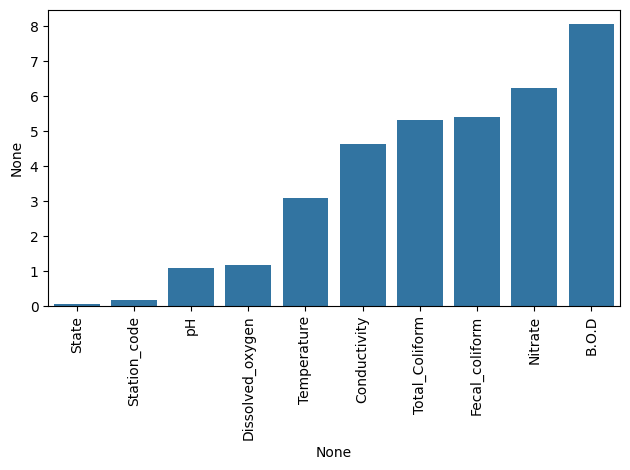

In [8]:
# visulaize the missing values:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.xticks(rotation=90);
plt.tight_layout()
# rotating everything for us as far as the features




---
### **Data Preprocessing**

---



**Filling Missing NAN Value**

In [9]:
import pandas as pd
import numpy as np

def comprehensive_missing_value_imputation(df, lookback_window):
    """
    Complete missing value imputation in one function with multiple fallback strategies:
    1. Station's historical average (configurable lookback window)
    2. River-Year-State median
    3. River-Year median
    4. River median
    5. Global median (last resort)
    """
    numeric_cols = ['Temperature', 'Dissolved_oxygen', 'pH', 'Conductivity',
                   'B.O.D', 'Nitrate', 'Fecal_coliform', 'Total_Coliform']
    numeric_cols = [col for col in numeric_cols if col in df.columns]

    # Pre-compute all possible median fallbacks
    print("Pre-computing median fallback values...")
    river_state_year_med = df.groupby(['River', 'State', 'Year'])[numeric_cols].median()
    river_year_med = df.groupby(['River', 'Year'])[numeric_cols].median()
    river_med = df.groupby('River')[numeric_cols].median()
    global_med = df[numeric_cols].median()

    def impute_station_data(group):
        for col in numeric_cols:
            # First pass: fill with historical station data
            if lookback_window:
                historical_avg = (group[col].rolling(window=lookback_window, min_periods=1).mean().shift())

            else:
                historical_avg = group[col].expanding().mean().shift()

            group[col] = group[col].fillna(historical_avg)

            # Second pass: fill remaining NAs with context-aware medians
            na_mask = group[col].isna()
            if na_mask.any():
                for idx in group.index[na_mask]:
                    river = group.at[idx, 'River']
                    state = group.at[idx, 'State']
                    year = group.at[idx, 'Year']

                    # Try most specific to least specific fallback
                    try:
                        group.at[idx, col] = river_state_year_med.loc[(river, state, year), col]
                    except KeyError:
                        try:
                            group.at[idx, col] = river_year_med.loc[(river, year), col]
                        except KeyError:
                            try:
                                group.at[idx, col] = river_med.loc[river, col]
                            except KeyError:
                                group.at[idx, col] = global_med[col]
        return group

    print("Performing imputation...")
    df_filled = df.groupby('Station_code', group_keys=False).apply(impute_station_data)

    # Final check - should be no missing values
    remaining_nas = df_filled[numeric_cols].isna().sum().sum()
    if remaining_nas > 0:
        print(f"Warning: {remaining_nas} missing values remain after imputation")

        # Fallback to global median for any stragglers
        df_filled[numeric_cols] = df_filled[numeric_cols].fillna(global_med)

    print("Imputation complete!")
    return df_filled.reset_index(drop=True)

**Using 3-year lookback window with median imputation for first years**

In [10]:
df_filled = comprehensive_missing_value_imputation(df, lookback_window=3)
df_filled.isnull().sum()

Pre-computing median fallback values...
Performing imputation...
Imputation complete!


<ipython-input-9-2a0846a585a5>:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby('Station_code', group_keys=False).apply(impute_station_data)


Station_code        0
River               0
Location            0
State               0
Year                0
Temperature         0
Dissolved_oxygen    0
pH                  0
Conductivity        0
B.O.D               0
Nitrate             0
Fecal_coliform      0
Total_Coliform      0
dtype: int64

In [11]:
df_filled.head()

Station_code    River                         Location            State  \
0        1241.0  NARMADA  NARMADA AT MANDLA NEAR ROAD BOG   MADHYA PRADESH   
1          44.0  NARMADA          NARMADA AT SETHAt lGHAT  MADHYA  PRADESH   
2        1240.0  NARMADA           NARMADA AT NARSINGHPUR   MADHYA PRADESH   
3        1234.0  NARMADA     NARMADA AT HOSHANGA BA D U S   MADHYA PRADESH   
4        2123.0  NARMADA  NARMADA AT KORIGHAT HOSHANGABAD   MADHYA PRADESH   

   Year  Temperature  Dissolved_oxygen   pH  Conductivity  B.O.D  Nitrate  \
0  2012         24.0               7.4  7.4         349.0    2.3     0.53   
1  2012         26.0               7.9  8.0         456.0    1.7     1.47   
2  2012         22.0               7.5  7.5         379.0    1.8     0.51   
3  2012         27.0               7.6  8.1         301.0    1.9     1.33   
4  2012         26.0               7.5  7.8         333.0    1.7     1.19   

   Fecal_coliform  Total_Coliform  
0             4.0            62.0  
1             3.0           237.0  
2             2.0           127.0  
3             7.0           230.0  
4             3.0           195.0

In [12]:
df_filled.isna().sum()

Station_code        0
River               0
Location            0
State               0
Year                0
Temperature         0
Dissolved_oxygen    0
pH                  0
Conductivity        0
B.O.D               0
Nitrate             0
Fecal_coliform      0
Total_Coliform      0
dtype: int64

**Outlier Detection and Handling**

In [13]:
def calculate_iqr_bounds(data, feature, k=1.5):
    """Calculate IQR bounds for winsorization"""
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    return lower_bound, upper_bound

def feature_specific_winsorization(data, features):
    """Apply different k values based on feature skewness with non-negative enforcement"""
    df_filled_data = data.copy()
    k_values = {
        'Dissolved_oxygen': 1.5,
        'pH': 1.5,
        'Conductivity': 2.0,
        'B.O.D': 3.0,
        'Nitrate': 3.0,
        'Fecal_coliform': 5.0,
        'Total_Coliform': 5.0
    }

    for feature in features:
        k = k_values.get(feature, 1.5)
        lower_bound, upper_bound = calculate_iqr_bounds(data, feature, k)

        # Enforce non-negative bounds (except pH)
        if feature not in ['pH']:
            lower_bound = max(lower_bound, 0)

        df_filled_data[feature] = df_filled_data[feature].clip(
            lower=lower_bound,
            upper=upper_bound
        )

    return df_filled_data

# Select features to winsorize
features_to_winsorize = ['Dissolved_oxygen', 'pH', 'Conductivity', 'B.O.D',
                        'Nitrate', 'Fecal_coliform', 'Total_Coliform']

# Apply winsorization
df_filled_data = feature_specific_winsorization(df_filled, features_to_winsorize)

# Apply domain-specific manual capping
manual_caps = {
    'Fecal_coliform': 1000,   # EPA recreational water standard
    'Total_Coliform': 5000,   # Common regulatory limit
    'B.O.D': 10,             # Typical threshold for polluted water
    'Conductivity': 1000      # High but plausible
}

for param, cap in manual_caps.items():
    df_filled_data[param] = df_filled_data[param].clip(upper=cap)

# Update original dataframe
df_filled[features_to_winsorize] = df_filled_data[features_to_winsorize]

---

**Adding Label column**

---



In [14]:
# --- WQI Calculation ---
params = features_to_winsorize

ideal_values = {
    'Dissolved_oxygen': 14.6,
    'pH': 7.0,
    'Conductivity': 0,
    'B.O.D': 0,
    'Nitrate': 0,
    'Fecal_coliform': 0,
    'Total_Coliform': 0
}

standard_values = {
    'Dissolved_oxygen': 5,
    'pH': 8.5,
    'Conductivity': 300,
    'B.O.D': 3,
    'Nitrate': 45,
    'Fecal_coliform': 2500,
    'Total_Coliform': 5000
}

# Compute weights
sum_si = sum(standard_values.values())
k = 1 / sum_si
weights = {param: k / si for param, si in standard_values.items()}

def compute_wqi_row(row):
    """Compute WQI for a single row with safeguards"""
    qi_values = {}
    for param in params:
        vi = row[param]
        vid = ideal_values[param]
        si = standard_values[param]

        try:
            qi = 100 * (vi - vid) / (si - vid)
        except ZeroDivisionError:
            qi = 0

        # Hard cap at 100 and floor at 0
        qi = max(min(qi, 100), 0)
        qi_values[param] = qi

    weighted_qi_sum = sum(qi_values[param] * weights[param] for param in params)
    total_weight = sum(weights.values())
    wqi = weighted_qi_sum / total_weight
    return round(wqi, 2)

# Compute WQI
df_filled['WQI'] = df_filled.apply(compute_wqi_row, axis=1)

# --- Validation ---
def validate_winsorization(original, df_filled, features):
    validation_results = {}

    for feature in features:
        q1 = original[feature].quantile(0.25)
        q3 = original[feature].quantile(0.75)
        iqr = q3 - q1
        k = {
            'Dissolved_oxygen': 1.5,
            'pH': 1.5,
            'Conductivity': 2.0,
            'B.O.D': 3.0,
            'Nitrate': 3.0,
            'Fecal_coliform': 5.0,
            'Total_Coliform': 5.0
        }.get(feature, 1.5)

        lower_bound = max(q1 - k * iqr, 0) if feature != 'pH' else q1 - k * iqr
        upper_bound = q3 + k * iqr

        # Check manual caps
        manual_cap = manual_caps.get(feature, None)
        if manual_cap:
            upper_bound = min(upper_bound, manual_cap)

        violations = df_filled[feature][(df_filled[feature] < lower_bound) | (df_filled[feature] > upper_bound)]

        validation_results[feature] = {
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'n_violations': len(violations),
            'max_value': df_filled[feature].max(),
            'min_value': df_filled[feature].min()
        }

    return pd.DataFrame(validation_results).T

validation_report = validate_winsorization(df_filled, df_filled_data, features_to_winsorize)
print("Winsorization Validation Report:")
display(validation_report)

Winsorization Validation Report:


lower_bound  upper_bound  n_violations  max_value  min_value
Dissolved_oxygen        3.350       10.950           0.0     10.950      3.350
pH                      6.625        8.825           0.0      8.825      6.625
Conductivity            0.000     1000.000           0.0   1000.000      0.000
B.O.D                   0.000       10.000           0.0     10.000      0.000
Nitrate                 0.000        4.500           0.0      4.500      0.000
Fecal_coliform          0.000     1000.000           0.0   1000.000      0.000
Total_Coliform          0.000     5000.000           0.0   5000.000      0.000

In [15]:
# Compute proportionality constant k
sum_si = sum(standard_values.values())
k = 1 / sum_si

# Compute weights wi = k / si
weights = {param: k / si for param, si in standard_values.items()}

# --- Step 3: Compute qi and WQI per row ---
def compute_wqi_row(row):
    qi_values = {}
    for param in params:
        vi = row[param]
        vid = ideal_values[param]
        si = standard_values[param]
        try:
            # Avoid division by zero
            qi = 100 * ((vi - vid) / (si - vid))
        except ZeroDivisionError:
            qi = 0
        # Remove negative qi
        qi = max(qi, 0)
        qi_values[param] = qi

    weighted_qi_sum = sum(qi_values[param] * weights[param] for param in params)
    total_weight = sum(weights.values())
    wqi = weighted_qi_sum / total_weight
    return round(wqi, 2)


In [16]:
# Apply WQI computation for each row
df_filled['WQI'] = df_filled.apply(compute_wqi_row, axis=1)

In [17]:
df_filled.head()

Station_code    River                         Location            State  \
0        1241.0  NARMADA  NARMADA AT MANDLA NEAR ROAD BOG   MADHYA PRADESH   
1          44.0  NARMADA          NARMADA AT SETHAt lGHAT  MADHYA  PRADESH   
2        1240.0  NARMADA           NARMADA AT NARSINGHPUR   MADHYA PRADESH   
3        1234.0  NARMADA     NARMADA AT HOSHANGA BA D U S   MADHYA PRADESH   
4        2123.0  NARMADA  NARMADA AT KORIGHAT HOSHANGABAD   MADHYA PRADESH   

   Year  Temperature  Dissolved_oxygen   pH  Conductivity  B.O.D  Nitrate  \
0  2012         24.0               7.4  7.4         349.0    2.3     0.53   
1  2012         26.0               7.9  8.0         456.0    1.7     1.47   
2  2012         22.0               7.5  7.5         379.0    1.8     0.51   
3  2012         27.0               7.6  8.1         301.0    1.9     1.33   
4  2012         26.0               7.5  7.8         333.0    1.7     1.19   

   Fecal_coliform  Total_Coliform    WQI  
0             4.0            62.0  65.14  
1             3.0           237.0  60.95  
2             2.0           127.0  57.83  
3             7.0           230.0  66.05  
4             3.0           195.0  59.64

In [18]:
df_filled.describe()

Station_code         Year  Temperature  Dissolved_oxygen           pH  \
count   2948.000000  2948.000000  2948.000000       2948.000000  2948.000000   
mean    3355.809701  2018.446065    22.389535          7.084063     7.720683   
std     4711.467501     3.431151     7.087663          1.538494     0.388993   
min        7.000000  2012.000000     0.000000          3.350000     6.625000   
25%     1202.000000  2016.000000    20.000000          6.200000     7.450000   
50%     2099.000000  2019.000000    24.000000          7.150000     7.750000   
75%     3123.000000  2021.000000    26.000000          8.100000     8.000000   
max    30088.000000  2023.000000   240.000000         10.950000     8.825000   

       Conductivity        B.O.D      Nitrate  Fecal_coliform  Total_Coliform  \
count   2948.000000  2948.000000  2948.000000     2948.000000     2948.000000   
mean     413.434820     3.062667     1.107099      424.437239     1906.612042   
std      262.734602     2.803697     1.265415      446.664382     2071.167040   
min        0.000000     0.000000     0.000000        0.000000        0.000000   
25%      245.375000     1.100000     0.300000        8.000000      127.000000   
50%      335.250000     2.000000     0.650000      170.000000      809.250000   
75%      521.125000     3.650000     1.350000     1000.000000     5000.000000   
max     1000.000000    10.000000     4.500000     1000.000000     5000.000000   

               WQI  
count  2948.000000  
mean     82.594932  
std      48.592212  
min      14.390000  
25%      50.115000  
50%      65.915000  
75%      94.090000  
max     220.890000

**Class Assigning**

<ipython-input-19-695de03bc879>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='WQI_Class', data=df_filled, palette='Set2')


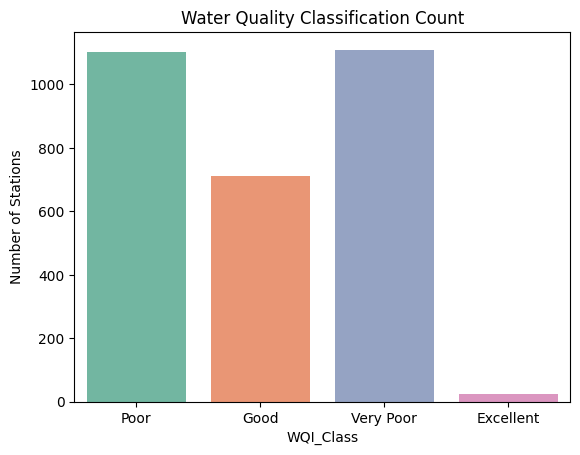

In [19]:
# Based on the literature ------>
def classify_wqi(wqi):
    if wqi <= 25:
        return 'Excellent'
    elif wqi <= 50:
        return 'Good'
    elif wqi <= 75:
        return 'Poor'
    else:
        return 'Very Poor'


df_filled['WQI_Class'] = df_filled['WQI'].apply(classify_wqi)

sns.countplot(x='WQI_Class', data=df_filled, palette='Set2')
plt.title('Water Quality Classification Count')
plt.ylabel('Number of Stations')
plt.show()

In [20]:
class_counts = df_filled['WQI_Class'].value_counts().sort_index()
class_counts

WQI_Class
Excellent      25
Good          710
Poor         1103
Very Poor    1110
Name: count, dtype: int64

In [21]:
df_filled.head(5)

Station_code    River                         Location            State  \
0        1241.0  NARMADA  NARMADA AT MANDLA NEAR ROAD BOG   MADHYA PRADESH   
1          44.0  NARMADA          NARMADA AT SETHAt lGHAT  MADHYA  PRADESH   
2        1240.0  NARMADA           NARMADA AT NARSINGHPUR   MADHYA PRADESH   
3        1234.0  NARMADA     NARMADA AT HOSHANGA BA D U S   MADHYA PRADESH   
4        2123.0  NARMADA  NARMADA AT KORIGHAT HOSHANGABAD   MADHYA PRADESH   

   Year  Temperature  Dissolved_oxygen   pH  Conductivity  B.O.D  Nitrate  \
0  2012         24.0               7.4  7.4         349.0    2.3     0.53   
1  2012         26.0               7.9  8.0         456.0    1.7     1.47   
2  2012         22.0               7.5  7.5         379.0    1.8     0.51   
3  2012         27.0               7.6  8.1         301.0    1.9     1.33   
4  2012         26.0               7.5  7.8         333.0    1.7     1.19   

   Fecal_coliform  Total_Coliform    WQI WQI_Class  
0             4.0            62.0  65.14      Poor  
1             3.0           237.0  60.95      Poor  
2             2.0           127.0  57.83      Poor  
3             7.0           230.0  66.05      Poor  
4             3.0           195.0  59.64      Poor

**Correlation Plot**

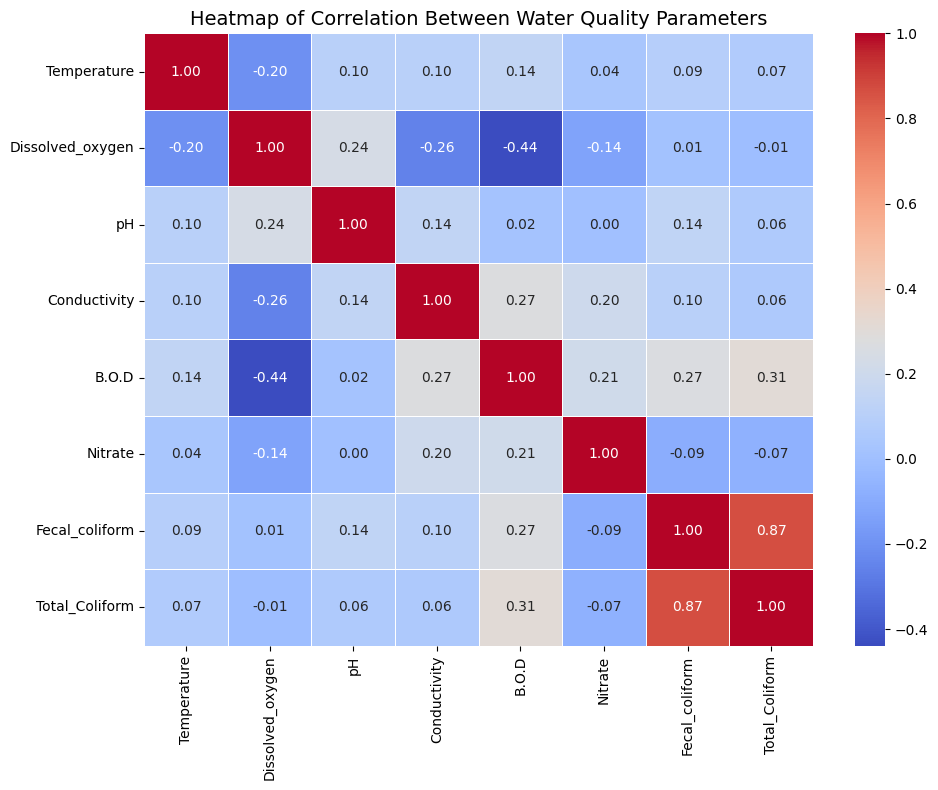

In [22]:
numeric_features = ['Temperature', 'Dissolved_oxygen', 'pH', 'Conductivity',
                    'B.O.D', 'Nitrate', 'Fecal_coliform', 'Total_Coliform']

# Compute the correlation matrix
correlation_matrix = df_filled[numeric_features].corr()

# Set the figure size and plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Correlation Between Water Quality Parameters", fontsize=14)
plt.tight_layout()
plt.show()

**Bar plot**

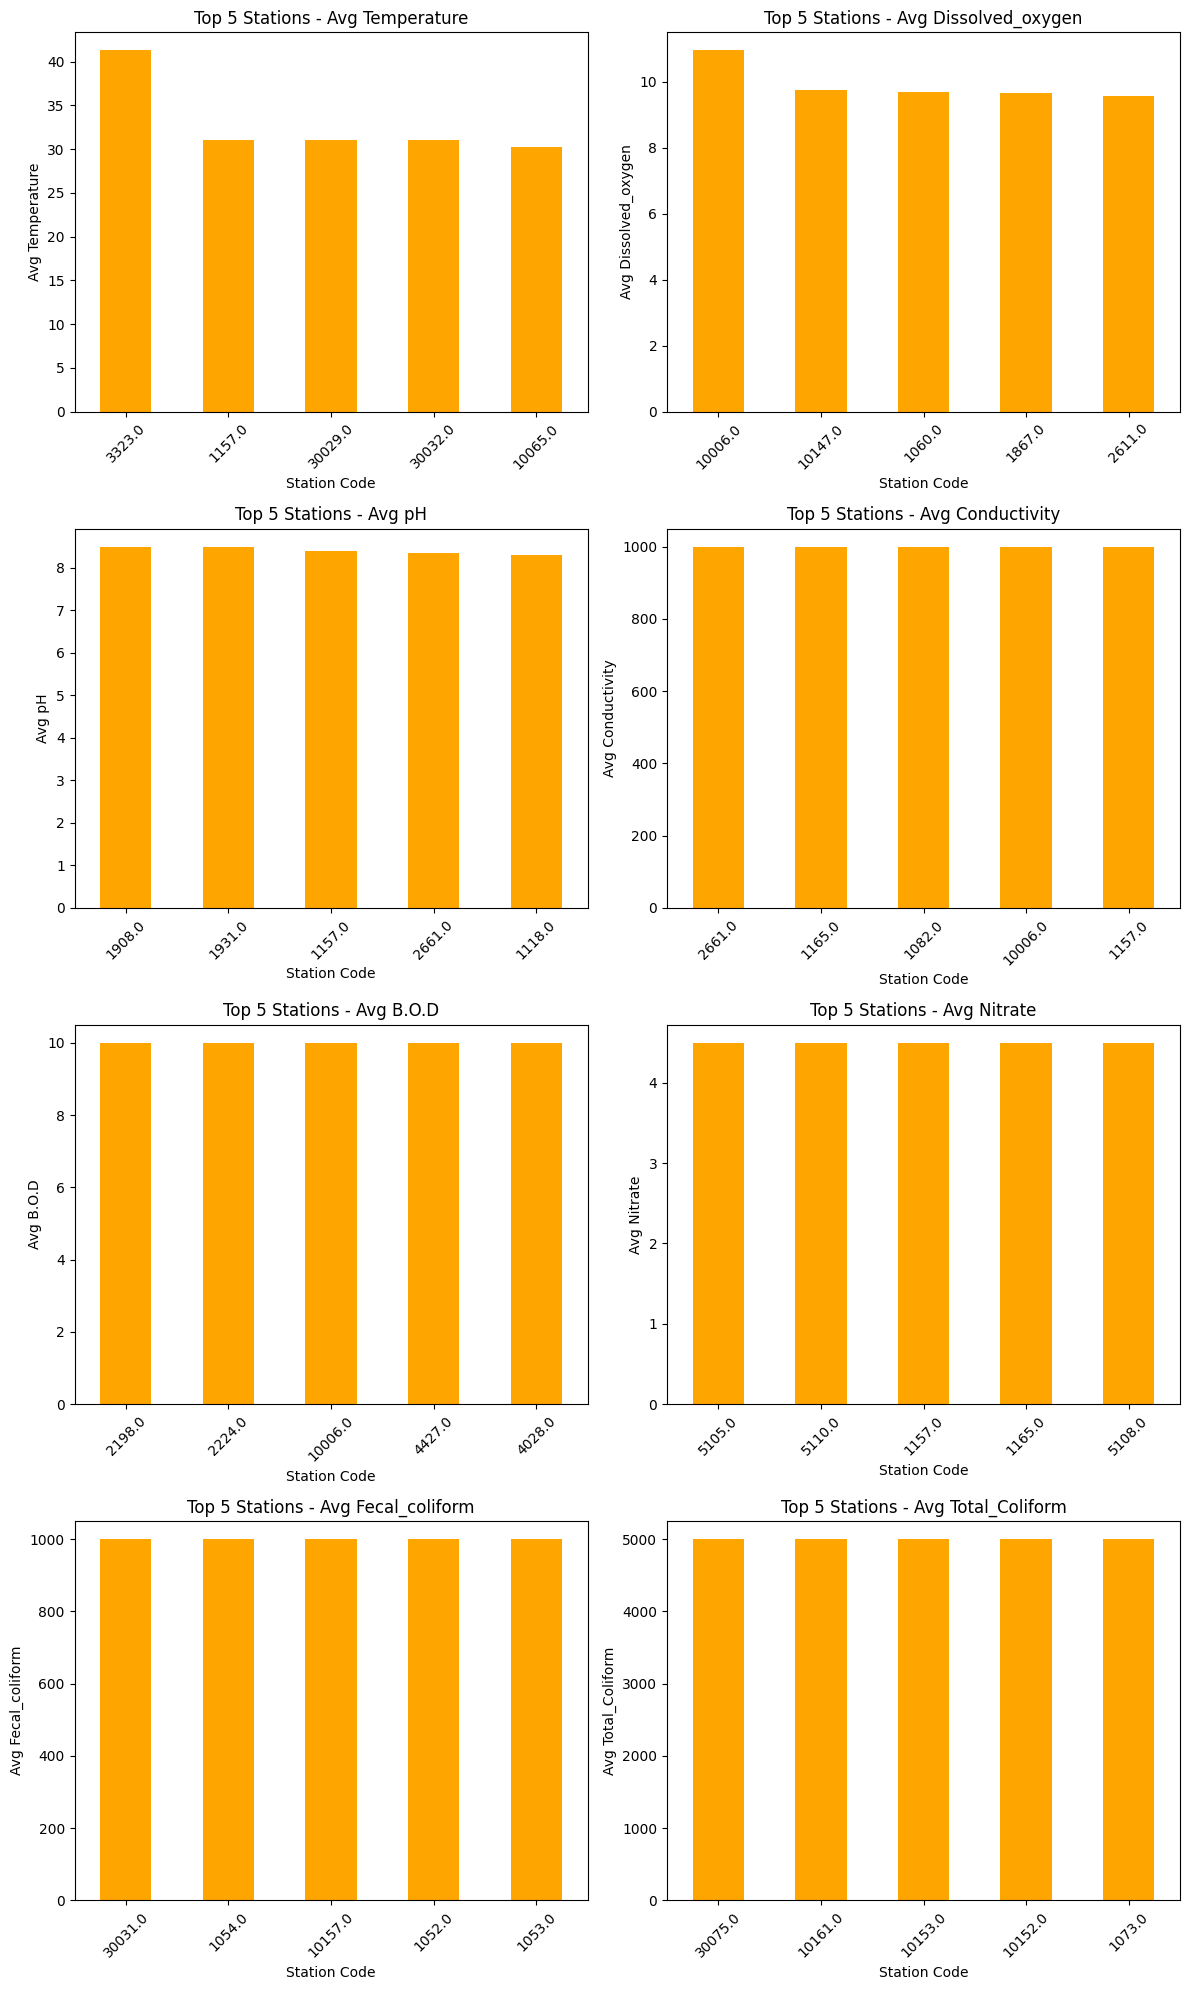

In [23]:
numeric_cols = ['Temperature', 'Dissolved_oxygen', 'pH', 'Conductivity', 'B.O.D', 'Nitrate', 'Fecal_coliform', 'Total_Coliform']
num_plots = len(numeric_cols)

# Define the number of columns and rows for subplots
cols = 2
rows = (num_plots + 1) // cols  # Ceiling division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = axes.flatten()  # Flatten in case of a single row

for i, col in enumerate(numeric_cols):
    top5 = df_filled.groupby("Station_code")[col].mean().sort_values(ascending=False).head(5)

    top5.plot(kind='bar', color='orange', ax=axes[i])
    axes[i].set_title(f"Top 5 Stations - Avg {col}")
    axes[i].set_xlabel("Station Code")
    axes[i].set_ylabel(f"Avg {col}")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### **ML MODEL APPLYING**

In [24]:
#  Encode WQI_Class
le = LabelEncoder()

df_filled['WQI_Class_Encoded'] = le.fit_transform(df_filled['WQI_Class'])


print("Label Encoding Map:")
for label, num in zip(le.classes_, le.transform(le.classes_)):
    print(f"'{label}' → {num}")

Label Encoding Map:
'Excellent' → 0
'Good' → 1
'Poor' → 2
'Very Poor' → 3


In [25]:
#Relevant Features
features = ['Temperature', 'Dissolved_oxygen', 'pH', 'Conductivity',
            'B.O.D', 'Nitrate', 'Fecal_coliform', 'Total_Coliform']


X = df_filled[features]
y = df_filled['WQI_Class_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DATA Balance using SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

#  Standardize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

df_filled.head()

Station_code    River                         Location            State  \
0        1241.0  NARMADA  NARMADA AT MANDLA NEAR ROAD BOG   MADHYA PRADESH   
1          44.0  NARMADA          NARMADA AT SETHAt lGHAT  MADHYA  PRADESH   
2        1240.0  NARMADA           NARMADA AT NARSINGHPUR   MADHYA PRADESH   
3        1234.0  NARMADA     NARMADA AT HOSHANGA BA D U S   MADHYA PRADESH   
4        2123.0  NARMADA  NARMADA AT KORIGHAT HOSHANGABAD   MADHYA PRADESH   

   Year  Temperature  Dissolved_oxygen   pH  Conductivity  B.O.D  Nitrate  \
0  2012         24.0               7.4  7.4         349.0    2.3     0.53   
1  2012         26.0               7.9  8.0         456.0    1.7     1.47   
2  2012         22.0               7.5  7.5         379.0    1.8     0.51   
3  2012         27.0               7.6  8.1         301.0    1.9     1.33   
4  2012         26.0               7.5  7.8         333.0    1.7     1.19   

   Fecal_coliform  Total_Coliform    WQI WQI_Class  WQI_Class_Encoded  
0             4.0            62.0  65.14      Poor                  2  
1             3.0           237.0  60.95      Poor                  2  
2             2.0           127.0  57.83      Poor                  2  
3             7.0           230.0  66.05      Poor                  2  
4             3.0           195.0  59.64      Poor                  2

GRID SEARCH LOGISTIC

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Hyperparameters: {'C': 100, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'lbfgs'}

 Train Accuracy: 0.9938202247191011
Test Accuracy : 0.9796610169491525

 Train Classification Report:
               precision    recall  f1-score   support

   Excellent       0.99      1.00      1.00       890
        Good       0.99      0.99      0.99       890
        Poor       0.99      0.99      0.99       890
   Very Poor       1.00      1.00      1.00       890

    accuracy                           0.99      3560
   macro avg       0.99      0.99      0.99      3560
weighted avg       0.99      0.99      0.99      3560


 Test Classification Report:
               precision    recall  f1-score   support

   Excellent       0.67      0.80      0.73         5
        Good       0.98      0.97      0.98       144
        Poor       0.97      0.99      0.98       221
   Very Poor       1.00      0.98      0.99       220

    accuracy                           0.98       590
   m

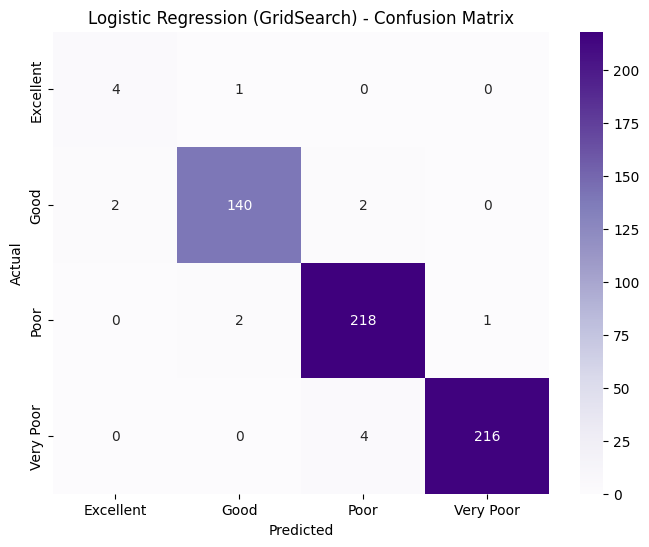

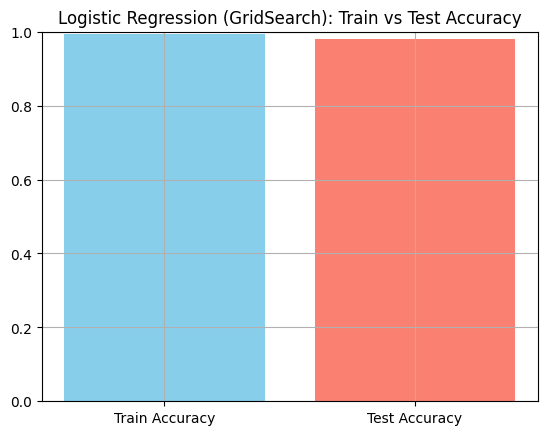

In [26]:
# Grid Search for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],
    'multi_class': ['multinomial'],
    'max_iter': [1000]
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train_scaled,  y_train_balanced)

print("Best Hyperparameters:", grid.best_params_)

best_model = grid.best_estimator_
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

train_acc_LR = accuracy_score( y_train_balanced, y_train_pred)
test_acc_LR = accuracy_score(y_test, y_test_pred)

#  Results
print("\n Train Accuracy:", train_acc_LR)
print("Test Accuracy :", test_acc_LR)

print("\n Train Classification Report:\n", classification_report( y_train_balanced, y_train_pred, target_names=le.classes_))
print("\n Test Classification Report:\n", classification_report(y_test, y_test_pred, target_names=le.classes_))

#  Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\n Confusion Matrix:\n", cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Logistic Regression (GridSearch) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#  Accuracy Comparison Plot
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc_LR, test_acc_LR], color=['skyblue', 'salmon'])
plt.title('Logistic Regression (GridSearch): Train vs Test Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


ROC CURVE FOR LOGISTIC

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

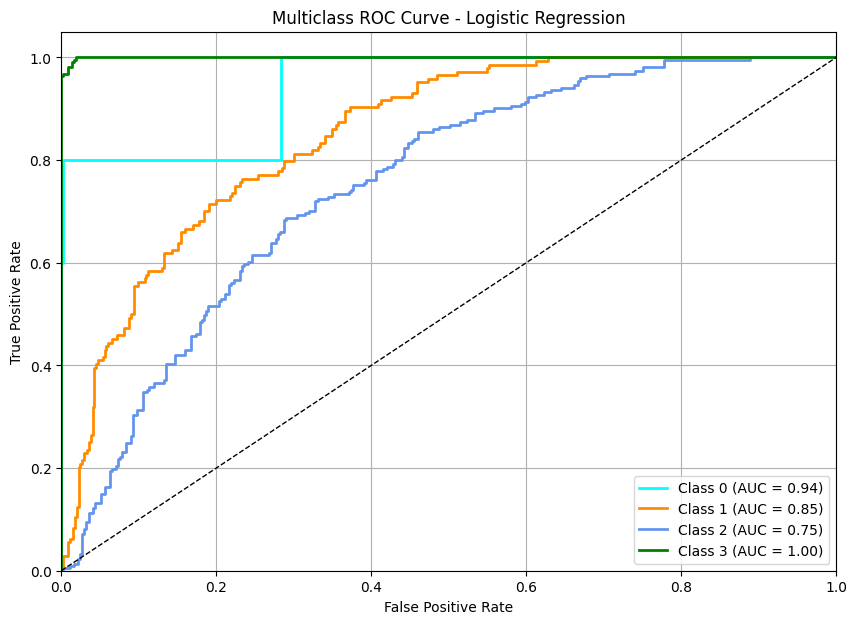

In [27]:
#  Binarize the target labels
y_train_bin = label_binarize(y_train_balanced, classes=[0, 1, 2, 3])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_train_bin.shape[1]

#  Train One-vs-Rest Logistic Regression
ovr_model = OneVsRestClassifier(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
ovr_model.fit(X_train_scaled, y_train_bin)


y_score = ovr_model.predict_proba(X_test_scaled)

# To Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
plt.figure(figsize=(10, 7))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


RANDOM FOREST


 RANDOM FOREST RESULTS
Train Accuracy: 1.0
Test Accuracy : 0.9440677966101695

Train Classification Report:
               precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00       890
        Good       1.00      1.00      1.00       890
        Poor       1.00      1.00      1.00       890
   Very Poor       1.00      1.00      1.00       890

    accuracy                           1.00      3560
   macro avg       1.00      1.00      1.00      3560
weighted avg       1.00      1.00      1.00      3560


Test Classification Report:
               precision    recall  f1-score   support

   Excellent       0.80      0.80      0.80         5
        Good       0.94      0.95      0.95       144
        Poor       0.94      0.92      0.93       221
   Very Poor       0.95      0.96      0.96       220

    accuracy                           0.94       590
   macro avg       0.91      0.91      0.91       590
weighted avg       0.94      0.94      0.94  

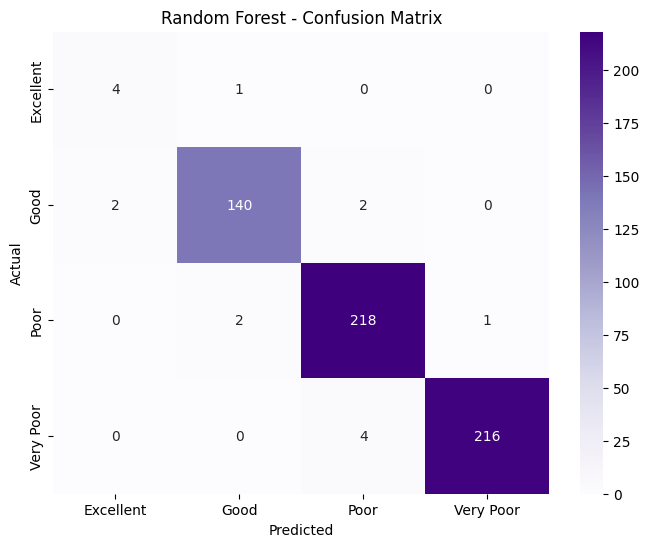

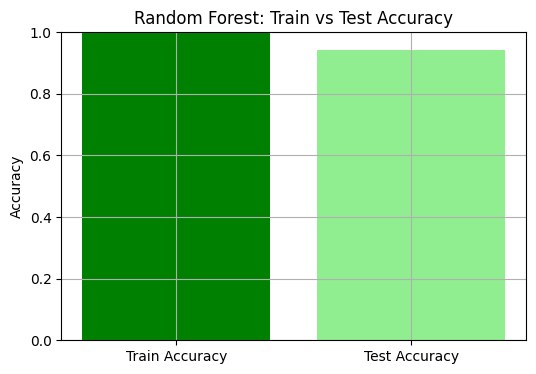

In [28]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_balanced)

y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Accuracy scores
train_acc_Rf = accuracy_score(y_train_balanced, y_train_pred)
test_acc_Rf = accuracy_score(y_test, y_test_pred)

# Evaluation
print("\n RANDOM FOREST RESULTS")
print("Train Accuracy:", train_acc_Rf)
print("Test Accuracy :", test_acc_Rf)

print("\nTrain Classification Report:\n", classification_report(y_train_balanced, y_train_pred, target_names=le.classes_))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred, target_names=le.classes_))

print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Accuracy Bar Plot
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc_Rf, test_acc_Rf], color=['green', 'lightgreen'])
plt.title('Random Forest: Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


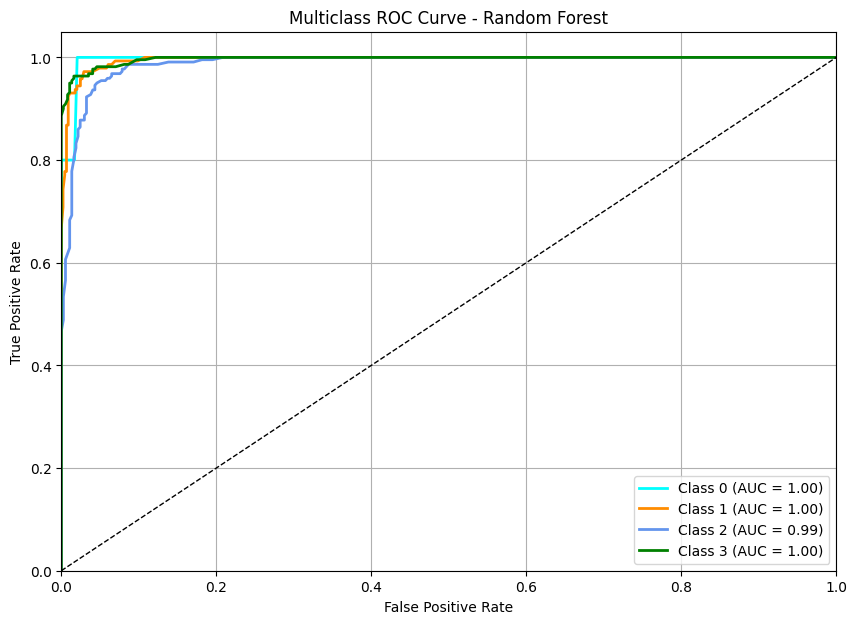

In [29]:
# Binarize the target classes (for ROC computation)
y_train_bin = label_binarize(y_train_balanced, classes=[0, 1, 2, 3])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_train_bin.shape[1]

ovr_rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
ovr_rf.fit(X_train_scaled, y_train_bin)

y_score_rf = ovr_rf.predict_proba(X_test_scaled)

#  ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
plt.figure(figsize=(10, 7))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


GRID SEARCH SVM

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters from Grid Search: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}

 Train Accuracy: 0.9926966292134831
 Test Accuracy : 0.976271186440678

 Train Classification Report:
               precision    recall  f1-score   support

   Excellent       0.99      1.00      1.00       890
        Good       0.99      0.99      0.99       890
        Poor       0.99      0.98      0.99       890
   Very Poor       1.00      1.00      1.00       890

    accuracy                           0.99      3560
   macro avg       0.99      0.99      0.99      3560
weighted avg       0.99      0.99      0.99      3560


 Test Classification Report:
               precision    recall  f1-score   support

   Excellent       0.67      0.80      0.73         5
        Good       0.96      0.98      0.97       144
        Poor       0.98      0.97      0.98       221
   Very Poor       1.00      0.98      0.99       220

    accuracy       

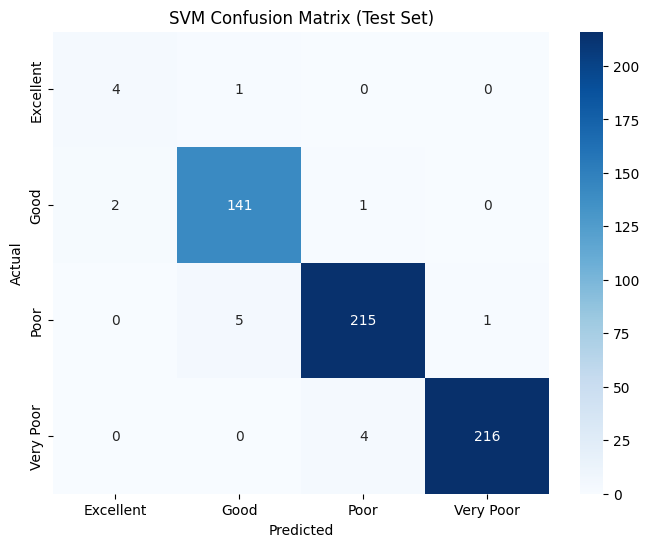

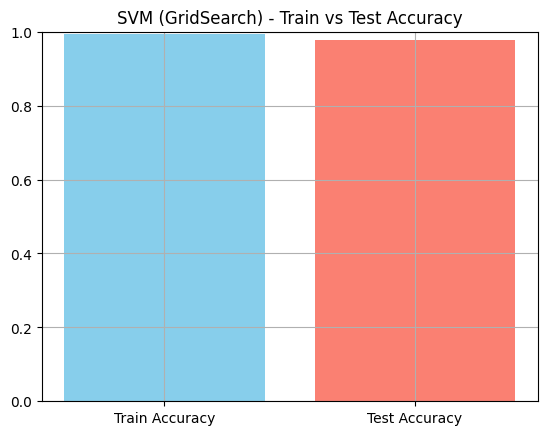

In [30]:
#  Grid Search for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf','linear']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train_scaled, y_train_balanced)

print("Best Parameters from Grid Search:", grid.best_params_)

best_svm = grid.best_estimator_

y_train_pred = best_svm.predict(X_train_scaled)
y_test_pred = best_svm.predict(X_test_scaled)

train_acc_SVM = accuracy_score(y_train_balanced, y_train_pred)
test_acc_SVM = accuracy_score(y_test, y_test_pred)

print("\n Train Accuracy:", train_acc_SVM)
print(" Test Accuracy :", test_acc_SVM)

print("\n Train Classification Report:\n", classification_report(y_train_balanced, y_train_pred, target_names=le.classes_))
print("\n Test Classification Report:\n", classification_report(y_test, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_test_pred)
print("\n Confusion Matrix:\n", cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("SVM Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc_SVM, test_acc_SVM], color=['skyblue', 'salmon'])
plt.title('SVM (GridSearch) - Train vs Test Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


ROC Curve for Multiclass SVM

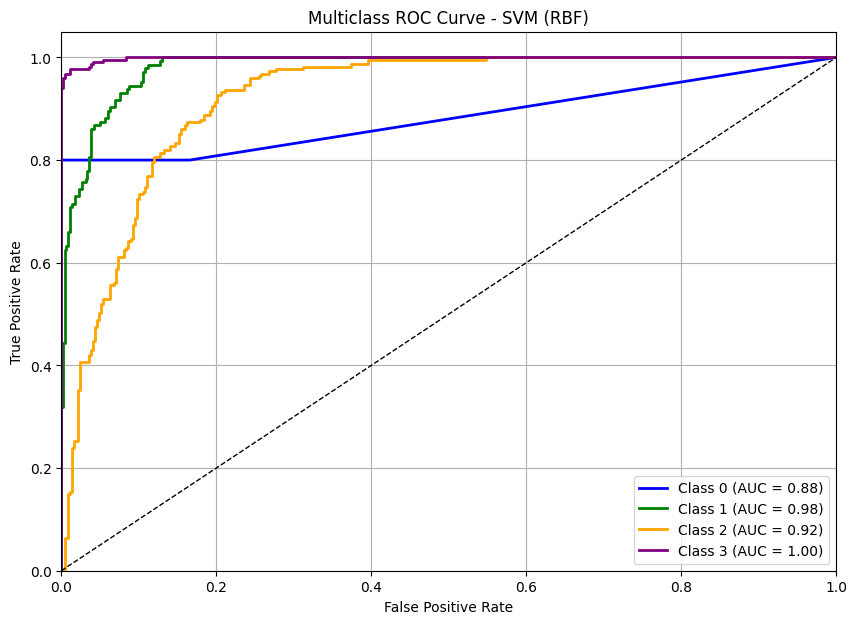

In [31]:

# Binarize the class labels
y_train_bin = label_binarize(y_train_balanced, classes=[0, 1, 2, 3])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_train_bin.shape[1]

# Use OneVsRest strategy to fit SVM for each class
from sklearn.svm import SVC
ovr_svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True, C=1.0, gamma='scale'))
ovr_svm.fit(X_train_scaled, y_train_bin)

y_score_svm = ovr_svm.predict_proba(X_test_scaled)

# FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#  ROC Curves
colors = cycle(['blue', 'green', 'orange', 'purple', 'red'])
plt.figure(figsize=(10, 7))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - SVM (RBF)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


DECISION TREE

Cross-Validation Scores (5-fold): [0.947 0.945 0.942 0.961 0.969]
Mean CV Accuracy: 0.953

Decision Tree Results (with CCP Regularization)
Train Accuracy: 0.9879213483146068
Test Accuracy : 0.940677966101695

Train Classification Report:
               precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00       890
        Good       0.97      0.99      0.98       890
        Poor       0.99      0.97      0.98       890
   Very Poor       1.00      0.99      1.00       890

    accuracy                           0.99      3560
   macro avg       0.99      0.99      0.99      3560
weighted avg       0.99      0.99      0.99      3560


Test Classification Report:
               precision    recall  f1-score   support

   Excellent       1.00      0.80      0.89         5
        Good       0.92      0.94      0.93       144
        Poor       0.93      0.91      0.92       221
   Very Poor       0.96      0.97      0.97       220

    accuracy            

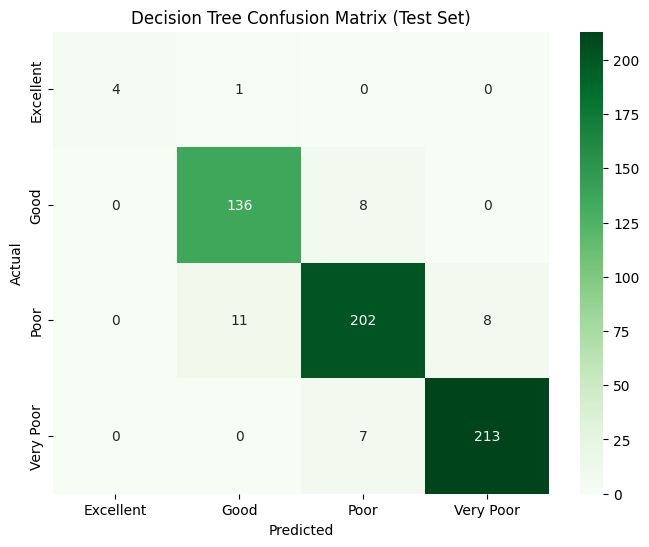

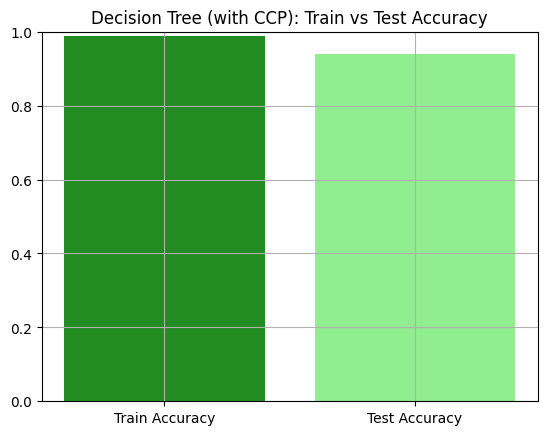

In [32]:
# Decision Tree with CCP Regularization
param_grid = {
        'ccp_alpha': [0.0, 0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

tree_model = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_balanced)

best_tree_model = grid_search.best_estimator_

# Cross-validation on training data
cv_scores = cross_val_score(best_tree_model, X_train_scaled, y_train_balanced, cv=5)
print("Cross-Validation Scores (5-fold):", np.round(cv_scores, 3))
print("Mean CV Accuracy:", round(cv_scores.mean(), 3))

# Predictions
y_train_pred = best_tree_model.predict(X_train_scaled)
y_test_pred = best_tree_model.predict(X_test_scaled)

# Evaluation
train_acc_DT = accuracy_score(y_train_balanced, y_train_pred)
test_acc_DT = accuracy_score(y_test, y_test_pred)

print("\nDecision Tree Results (with CCP Regularization)")
print("Train Accuracy:", train_acc_DT)
print("Test Accuracy :", test_acc_DT)

print("\nTrain Classification Report:\n", classification_report(y_train_balanced, y_train_pred, target_names=le.classes_))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Decision Tree Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Train vs Test Accuracy Bar Plot
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc_DT, test_acc_DT], color=['forestgreen', 'lightgreen'])
plt.title('Decision Tree (with CCP): Train vs Test Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

ROC Curve for Decision Tree Classifier

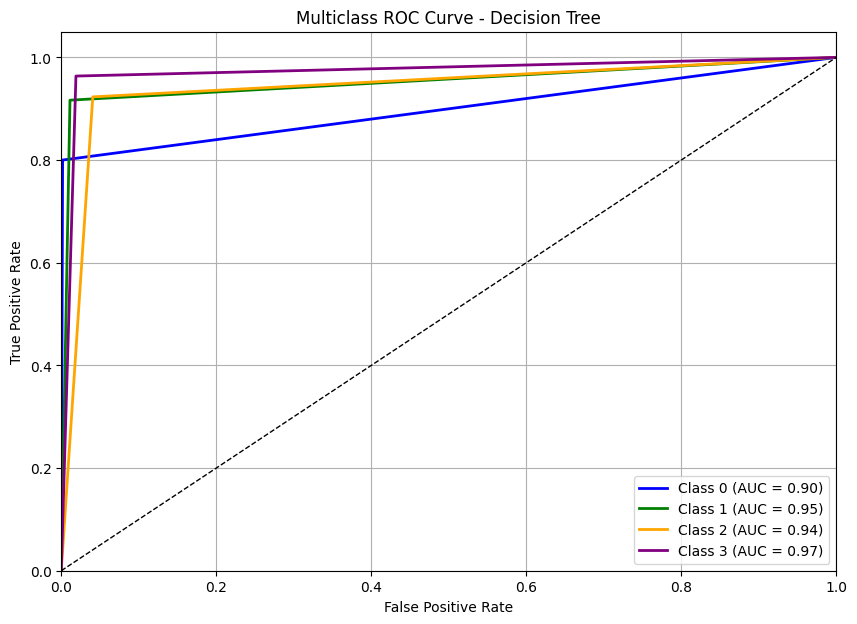

In [33]:
# Binarize labels
y_train_bin = label_binarize(y_train_balanced, classes=[0, 1, 2, 3])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_train_bin.shape[1]

# Train One-vs-Rest Decision Tree model
ovr_tree = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
ovr_tree.fit(X_train_scaled, y_train_bin)

# Predict probabilities
y_score_tree = ovr_tree.predict_proba(X_test_scaled)

# Compute ROC and AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_tree[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
colors = cycle(['blue', 'green', 'orange', 'purple', 'red'])
plt.figure(figsize=(10, 7))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


XGBOOST

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

 Cross-Validation Scores (5-fold): [0.985 0.969 0.975 0.986 0.979]
 Mean CV Accuracy: 0.979


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Train Accuracy: 1.0
 Test Accuracy : 0.9627118644067797

 Train Classification Report:
               precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00       890
        Good       1.00      1.00      1.00       890
        Poor       1.00      1.00      1.00       890
   Very Poor       1.00      1.00      1.00       890

    accuracy                           1.00      3560
   macro avg       1.00      1.00      1.00      3560
weighted avg       1.00      1.00      1.00      3560


 Test Classification Report:
               precision    recall  f1-score   support

   Excellent       1.00      0.80      0.89         5
        Good       0.98      0.94      0.96       144
        Poor       0.94      0.97      0.95       221
   Very Poor       0.98      0.97      0.97       220

    accuracy                           0.96       590
   macro avg       0.97      0.92      0.94       590
weighted avg       0.96      0.96      0.96       590


 Confusi

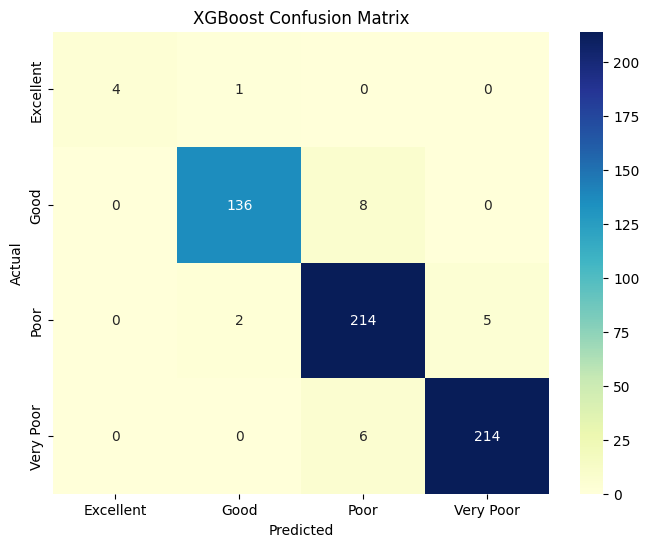

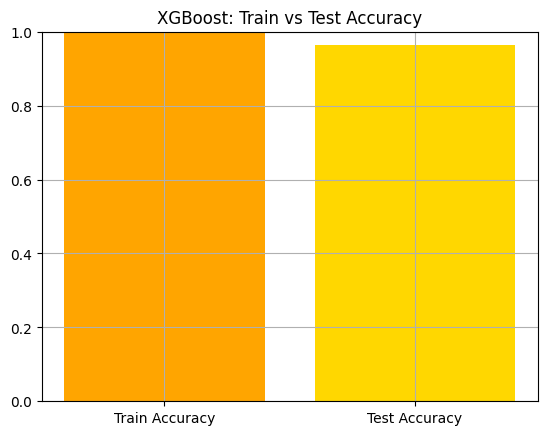

In [34]:
#  XGBoost model with cross-validation

xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), eval_metric='mlogloss', use_label_encoder=False)
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train_balanced, cv=5)

print(" Cross-Validation Scores (5-fold):", np.round(cv_scores, 3))
print(" Mean CV Accuracy:", round(cv_scores.mean(), 3))

#  Train final model
xgb_model.fit(X_train_scaled, y_train_balanced)

#  Predictions
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

train_acc_XGBOOST = accuracy_score(y_train_balanced, y_train_pred)
test_acc_XGBOOST = accuracy_score(y_test, y_test_pred)

#  Evaluation
print("\n Train Accuracy:", train_acc_XGBOOST)
print(" Test Accuracy :",test_acc_XGBOOST)

print("\n Train Classification Report:\n", classification_report(y_train_balanced, y_train_pred, target_names=le.classes_))
print("\n Test Classification Report:\n", classification_report(y_test, y_test_pred, target_names=le.classes_))

#  Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\n Confusion Matrix:\n", cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Train vs Test Accuracy Bar Plot
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc_XGBOOST, test_acc_XGBOOST], color=['orange', 'gold'])
plt.title('XGBoost: Train vs Test Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


ROC CURVE FOR XGBOOST

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


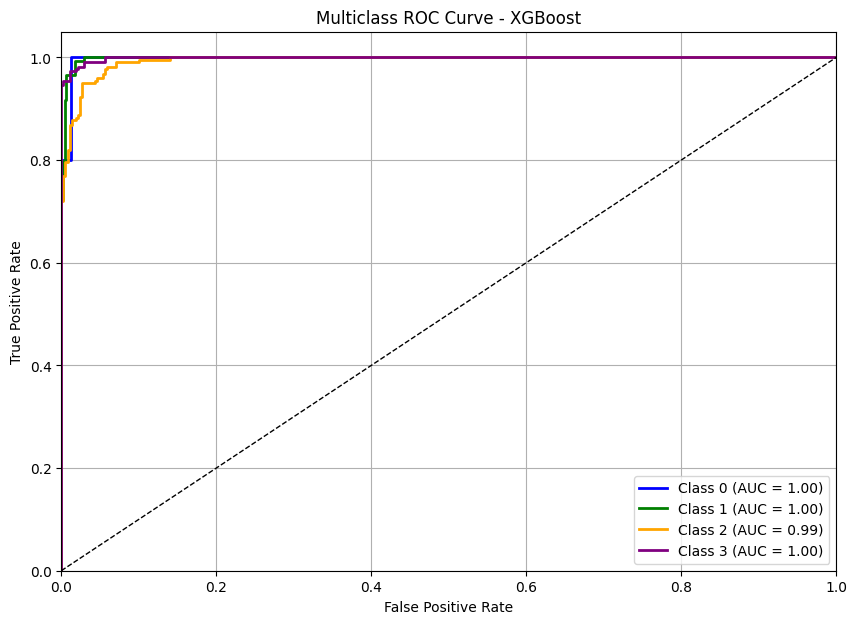

In [35]:
# Binarize labels
y_train_bin = label_binarize(y_train_balanced, classes=[0, 1, 2, 3])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_train_bin.shape[1]

# Train One-vs-Rest XGBoost model
ovr_xgb = OneVsRestClassifier(XGBClassifier(eval_metric='mlogloss', use_label_encoder=False))
ovr_xgb.fit(X_train_scaled, y_train_bin)

# probabilities
y_score_xgb = ovr_xgb.predict_proba(X_test_scaled)

#  ROC and AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
colors = cycle(['blue', 'green', 'orange', 'purple', 'red'])
plt.figure(figsize=(10, 7))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


MLP

 MLP RESULTS
Train Accuracy: 1.0
Test Accuracy : 0.976271186440678

Train Classification Report:
               precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00       890
        Good       1.00      1.00      1.00       890
        Poor       1.00      1.00      1.00       890
   Very Poor       1.00      1.00      1.00       890

    accuracy                           1.00      3560
   macro avg       1.00      1.00      1.00      3560
weighted avg       1.00      1.00      1.00      3560


Test Classification Report:
               precision    recall  f1-score   support

   Excellent       1.00      0.80      0.89         5
        Good       0.97      0.97      0.97       144
        Poor       0.96      0.98      0.97       221
   Very Poor       0.99      0.98      0.99       220

    accuracy                           0.98       590
   macro avg       0.98      0.93      0.95       590
weighted avg       0.98      0.98      0.98       590



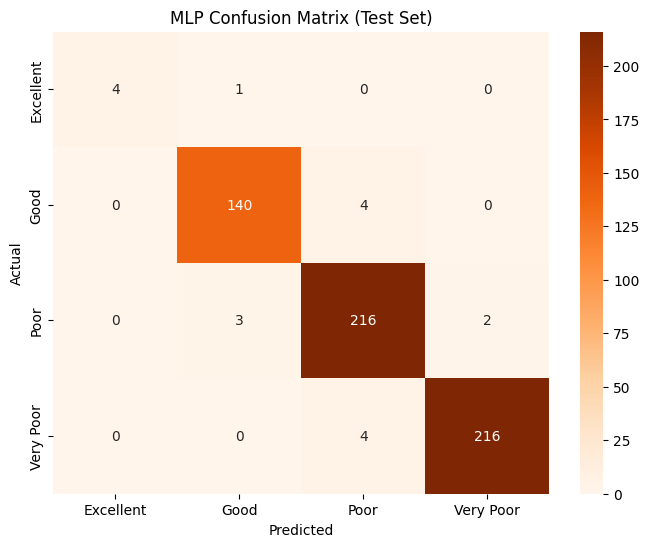

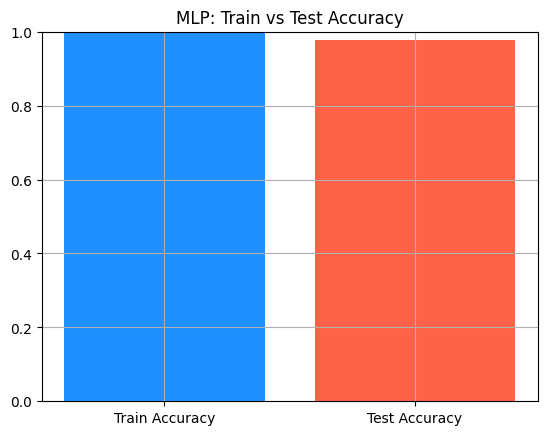

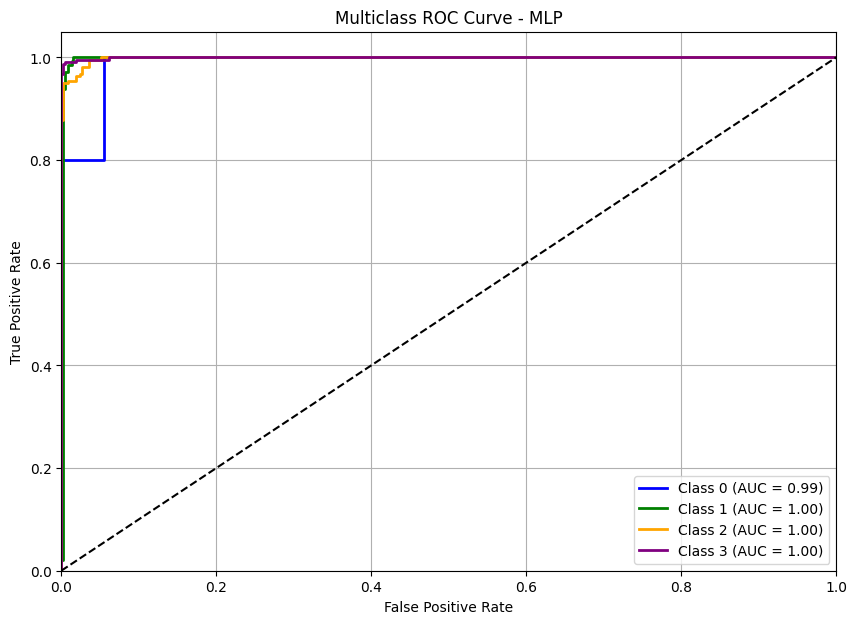

In [36]:
# Train MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                    max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train_balanced)

#  Predictions
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)

train_acc_MLP = accuracy_score(y_train_balanced, y_train_pred)
test_acc_MLP = accuracy_score(y_test, y_test_pred)

print(" MLP RESULTS")
print("Train Accuracy:", train_acc_MLP)
print("Test Accuracy :", test_acc_MLP)
print("\nTrain Classification Report:\n", classification_report(y_train_balanced, y_train_pred, target_names=le.classes_))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#  Accuracy Bar Plot
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc_MLP, test_acc_MLP], color=['dodgerblue', 'tomato'])
plt.title('MLP: Train vs Test Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

#  ROC Curve
y_train_bin = label_binarize(y_train_balanced, classes=[0,1,2,3])
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
n_classes = y_train_bin.shape[1]

# One-vs-rest for ROC
ovr_mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(100,50), max_iter=500, random_state=42))
ovr_mlp.fit(X_train_scaled, y_train_bin)
y_score = ovr_mlp.predict_proba(X_test_scaled)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#  ROC PLOT
colors = cycle(['blue', 'green', 'orange', 'purple', 'red'])
plt.figure(figsize=(10, 7))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - MLP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [37]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM (RBF)', 'XGBoost', 'MLP']

train_accuracies = [
    train_acc_LR ,  # Logistic Regression
    train_acc_DT,  # Decision Tree
    train_acc_Rf,  # Random Forest
    train_acc_SVM,  # SVM (RBF)
    train_acc_XGBOOST,  # XGBoost
    train_acc_MLP # MLP
]

test_accuracies = [
    test_acc_LR,  # Logistic Regression
    test_acc_DT,  # Decision Tree
    test_acc_Rf,  # Random Forest
    test_acc_SVM,  # SVM (RBF)
    test_acc_XGBOOST,  # XGBoost
    test_acc_MLP  # MLP
]


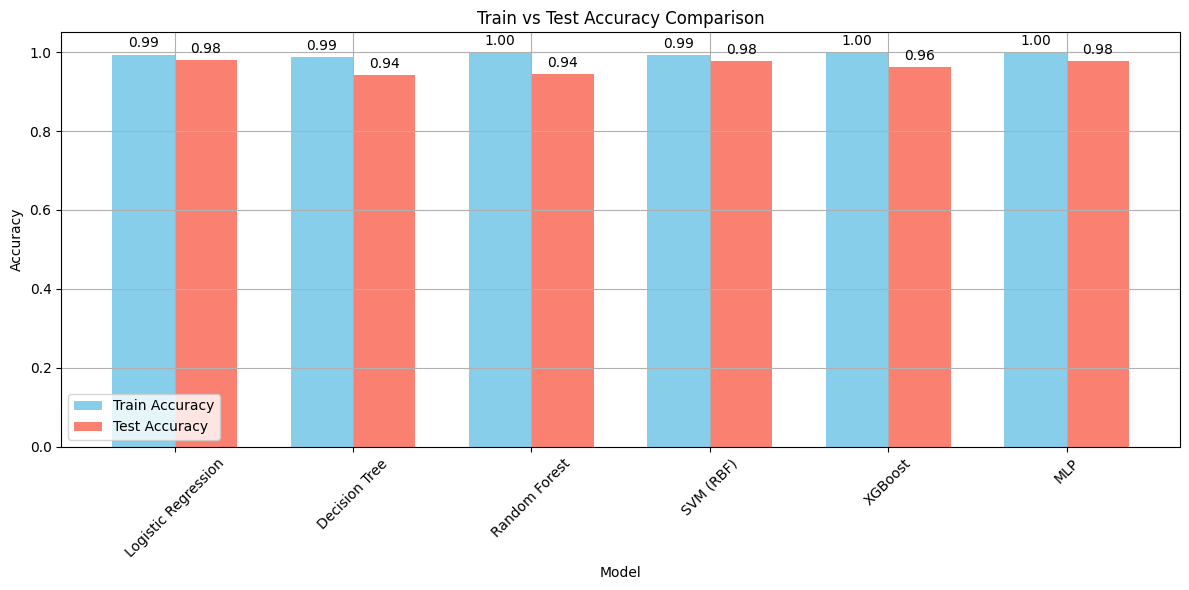

In [38]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='salmon')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(True)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Explanable AI Lime and Shape for XGBOOST

In [39]:
!pip install lime

In [40]:
import lime
import lime.lime_tabular
import shap

# ----- LIME -----
# Create a LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train.columns,
    class_names=np.unique(y_train_balanced).astype(str),
    mode='classification'
)

# Choose an instance to explain
i = 5  # Pick any test sample

exp = lime_explainer.explain_instance(
    data_row=X_test_scaled[i],
    predict_fn=xgb_model.predict_proba
)

exp.show_in_notebook(show_table=True)




SHAP values shape: (590, 8, 4)
X_test_scaled shape: (590, 8)

--- SHAP Force Plot for Class 0 (Excellent) ---


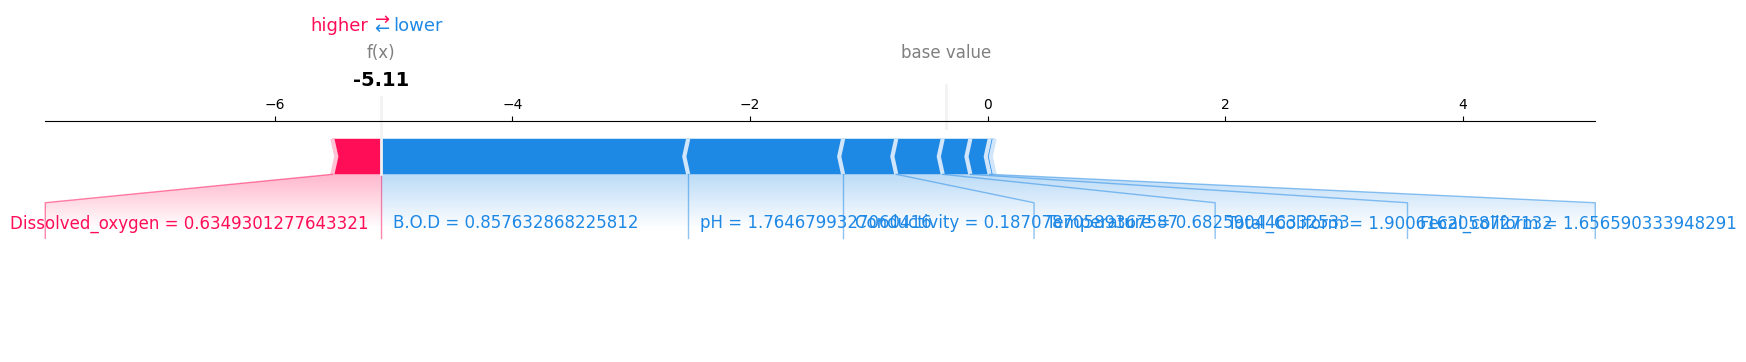


--- SHAP Force Plot for Class 1 (Good) ---


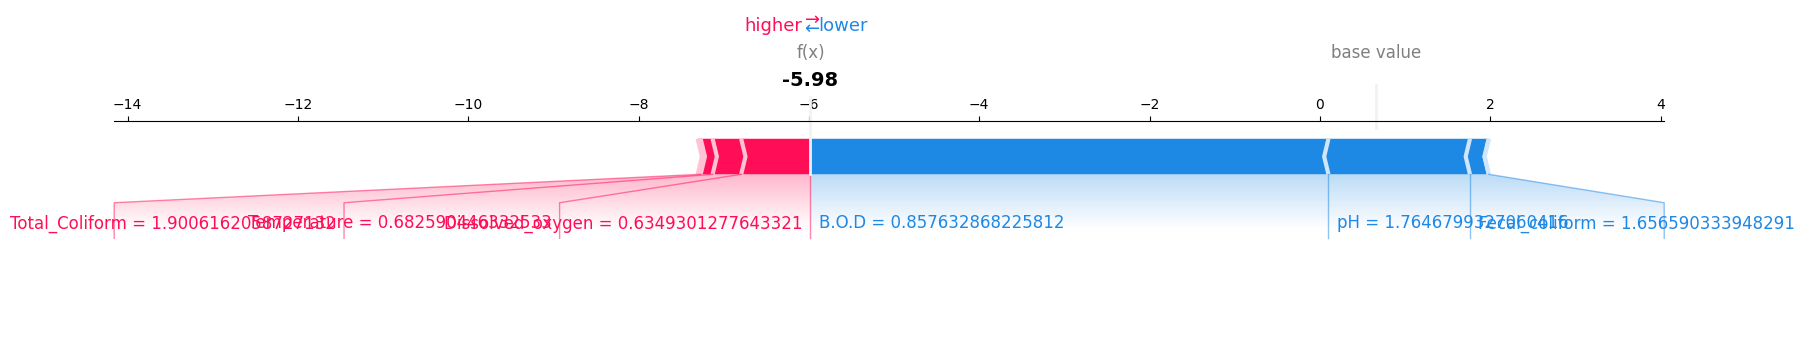


--- SHAP Force Plot for Class 2 (Poor) ---


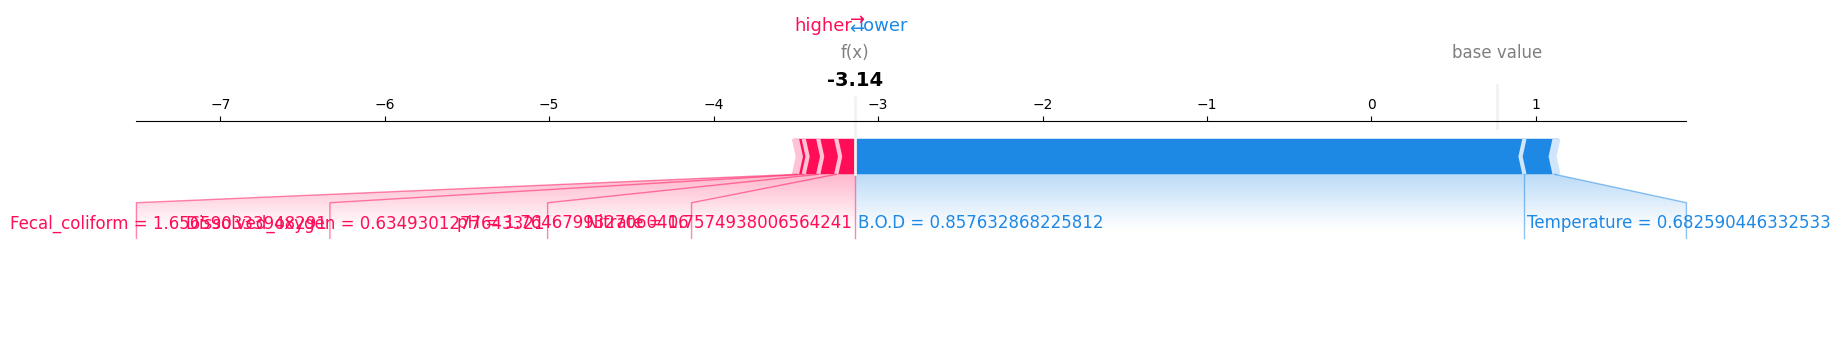


--- SHAP Force Plot for Class 3 (Very Poor) ---


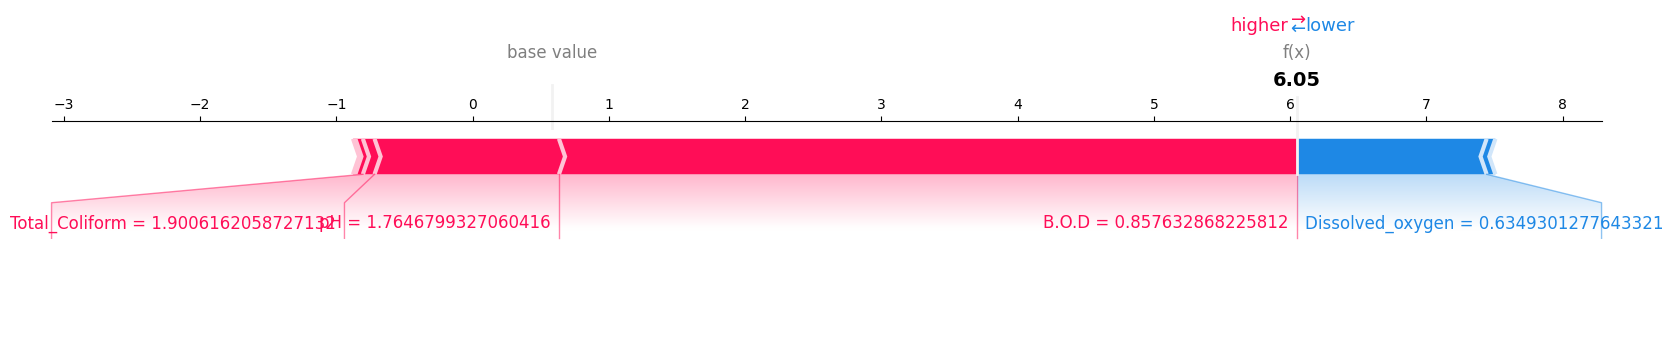

<Figure size 640x480 with 0 Axes>

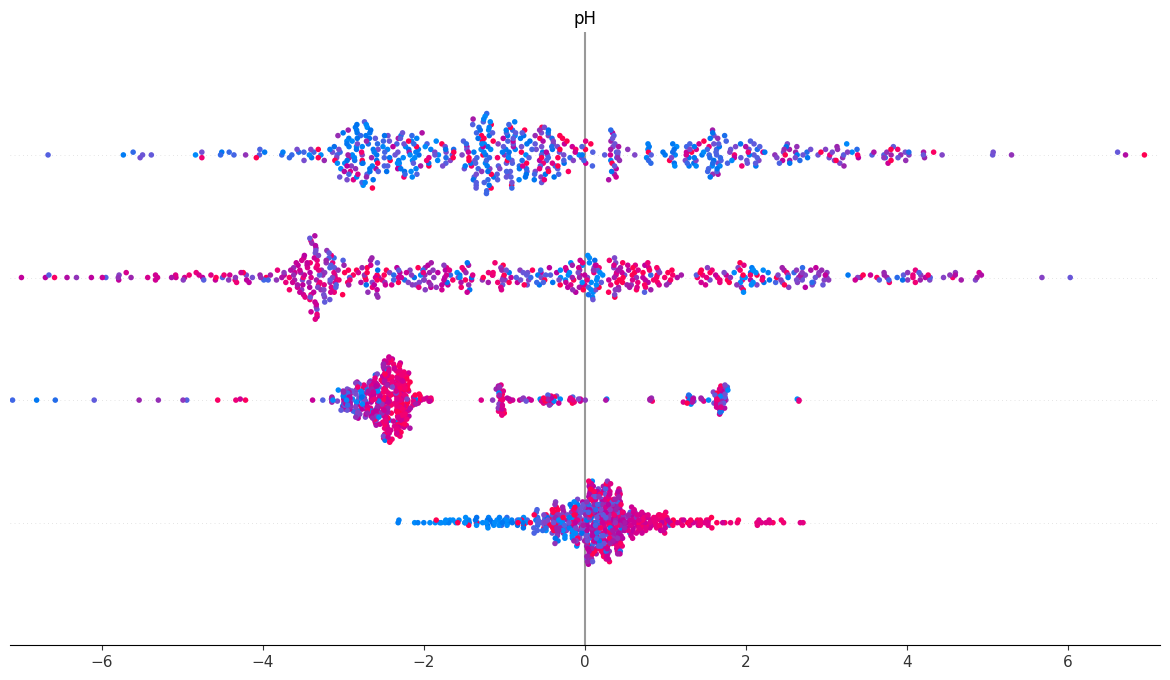

In [41]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Create correct SHAP explainer ---
explainer = shap.TreeExplainer(xgb_model)  # NOT model.predict

# --- 2. Compute SHAP values on scaled test data ---
shap_values = explainer.shap_values(X_test_scaled)

# --- 3. Check shapes (for verification) ---
print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# --- 4. Select one sample ---
i = 0  # you can change the sample index if you want
sample = pd.DataFrame(X_test_scaled, columns=X_test.columns).iloc[[i]]

class_index = 0  # or 1, 2, 3 depending on which class you want

# Now select shap values only for that class
shap_values_class = shap_values[:, :, class_index]  # (590, 8)

# Then plot
# shap.force_plot(
#     explainer.expected_value[class_index],  # expected value for that class
#     shap_values_class[i],                   # shap values for sample i, class 'class_index'
#     sample.values[0],                       # feature values
#     feature_names=X_test.columns,
#     matplotlib=True
# )


for class_idx in range(4):  # 4 classes
    print(f"\n--- SHAP Force Plot for Class {class_idx} ({le.classes_[class_idx]}) ---")
    shap.force_plot(
        explainer.expected_value[class_idx],
        shap_values[:, :, class_idx][i],
        sample.values[0],
        feature_names=X_test.columns,
        matplotlib=True
    )


# Summary plot for overall feature importance
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)


##For logistic regression


In [42]:
import lime
import lime.lime_tabular

# --- Create LIME Explainer ---
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train.columns,
    class_names=np.unique(y_train_balanced).astype(str),
    mode='classification'
)

# --- Choose an instance to explain ---
i = 5  # you can change sample index

# --- Explain instance ---
exp = lime_explainer.explain_instance(
    data_row=X_test_scaled[i],           # important: just use array, not iloc
    predict_fn=best_model.predict_proba  # for LIME, we use predict_proba
)

# --- Show explanation ---
exp.show_in_notebook(show_table=True)


SHAP values shape: (590, 8, 4)
X_test_scaled shape: (590, 8)

--- SHAP Force Plot for Class 0 (Excellent) ---


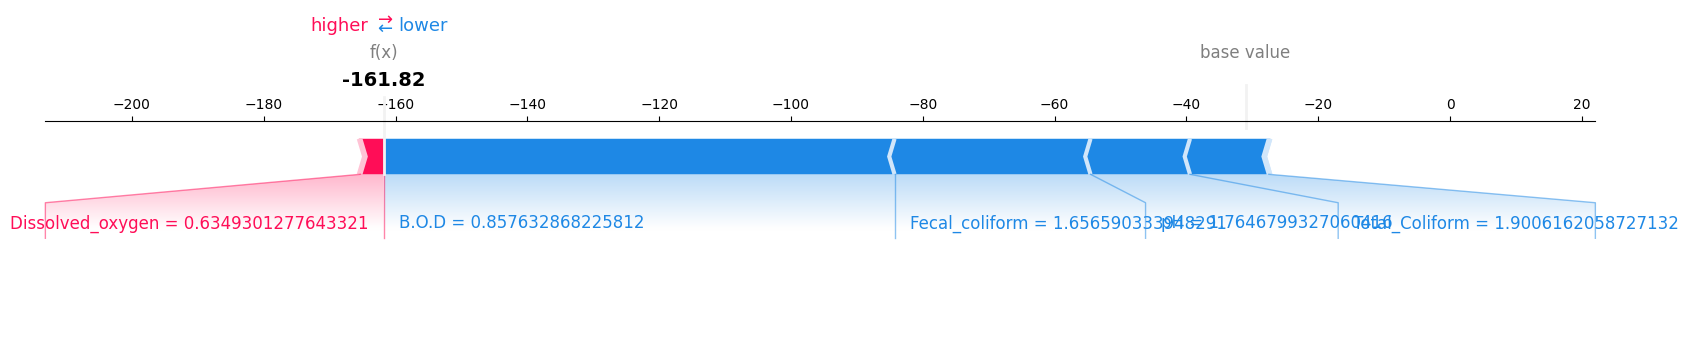


--- SHAP Force Plot for Class 1 (Good) ---


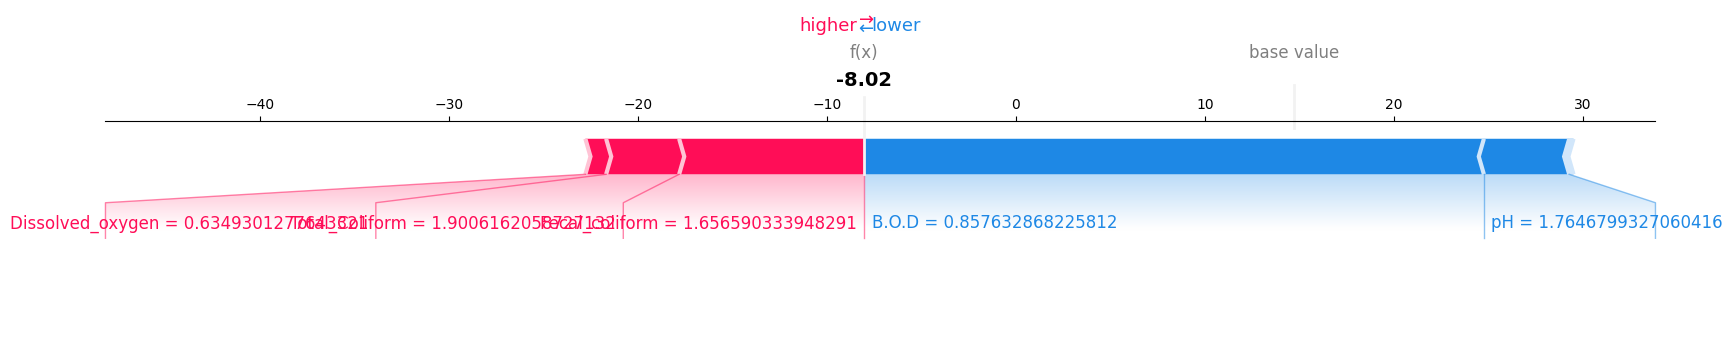


--- SHAP Force Plot for Class 2 (Poor) ---


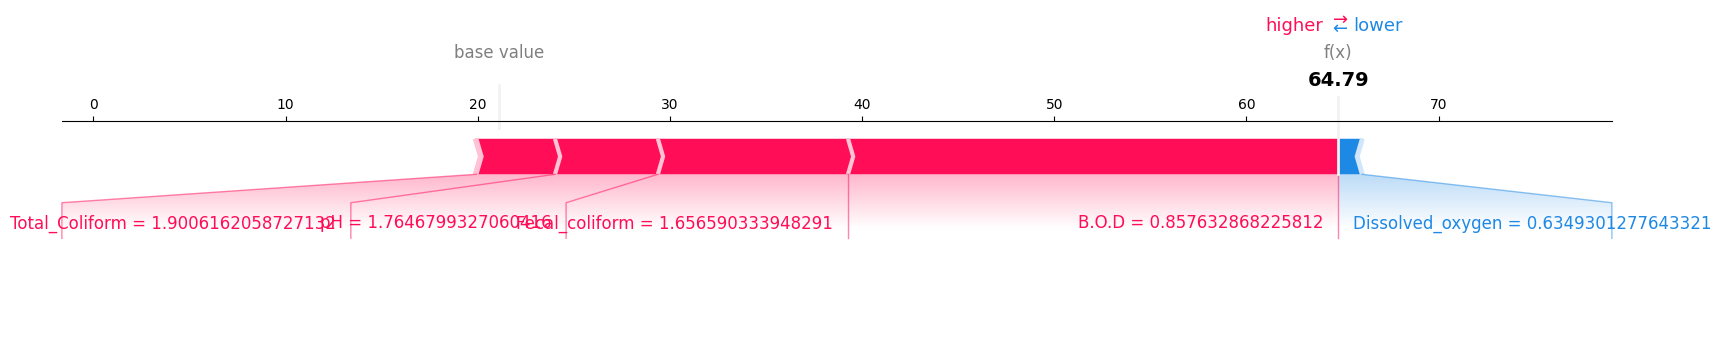


--- SHAP Force Plot for Class 3 (Very Poor) ---


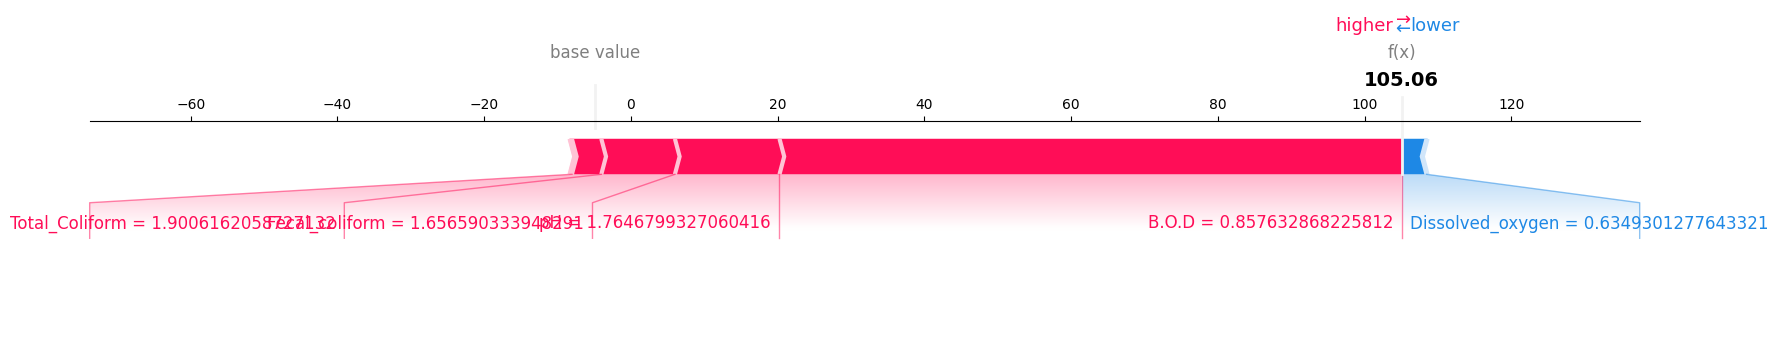

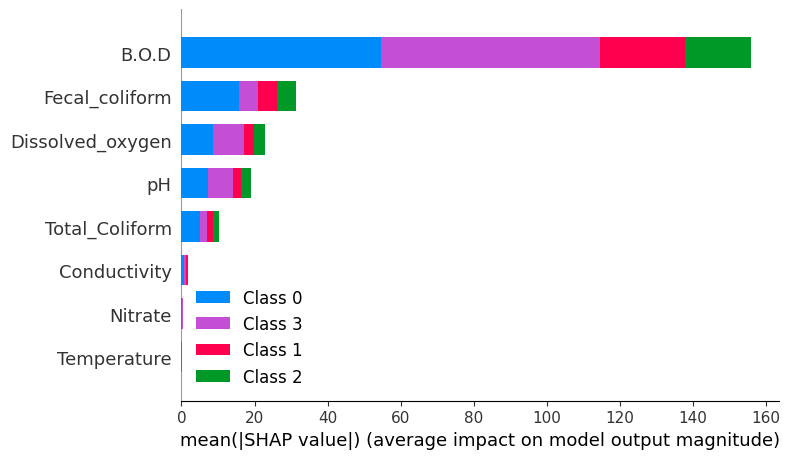

In [43]:
# --- 1. Create SHAP Explainer ---
explainer = shap.Explainer(best_model, X_train_scaled)

# --- 2. Compute SHAP values on test set ---
shap_values = explainer(X_test_scaled)

# --- 3. Check shapes ---
print(f"SHAP values shape: {shap_values.values.shape}")  # (590, 8, 4)
print(f"X_test_scaled shape: {X_test_scaled.shape}")     # (590, 8)

# --- 4. Select one sample ---
i = 0  # sample index
sample = pd.DataFrame(X_test_scaled, columns=X_test.columns).iloc[[i]]

# --- 5. Correct Force Plot with Feature Names ---
# class_index = 0  # pick 0, 1, 2, or 3
# print(f"Force plot for class label: {le.classes_[class_index]}")

# shap.plots.force(
#     base_value=explainer.expected_value[class_index],          # expected value
#     shap_values=shap_values.values[i,:,class_index],            # shap values for sample i, class_index
#     features=sample.values[0],
#     feature_names=X_test.columns,
#     matplotlib=True
# )

for class_idx in range(4):  # if 4 classes
    print(f"\n--- SHAP Force Plot for Class {class_idx} ({le.classes_[class_idx]}) ---")
    shap.plots.force(
        base_value=explainer.expected_value[class_idx],
        shap_values=shap_values.values[i,:,class_idx],
        features=sample.values[0],
        feature_names=X_test.columns,
        matplotlib=True
    )



# --- 6. Summary plot for overall feature importance ---
shap.summary_plot(shap_values, feature_names=X_test.columns)
# shap.summary_plot(shap_values[:,:,class_index], X_test_scaled, feature_names=X_test.columns)


## Model Agnostic XAI with SHAP
### Illustration with MLP

In [44]:
# imports
import shap
shap.initjs()

# preparations
features = ['Temperature', 'Dissolved_oxygen', 'pH', 'Conductivity','B.O.D', 'Nitrate', 'Fecal_coliform', 'Total_Coliform']
class_names = list(le.classes_)

### Defining the usage functions - class wise

In [60]:
 def compute_shap(model, X_train, X_test, nsamples=100, feature_names = None, output_names = None):
    """
    Compute SHAP values with model agnostic KernelExplainer return explainer and the explanation.
    """
    background = shap.sample(X_train, nsamples, random_state=0)
    print(f"Collected {nsamples} for background distribution.")
    explainer = shap.KernelExplainer(model.predict_proba, background, feature_names=features, link='logit')
    print("Explainer initialized.")

    print("Computing SHAP Explanations...")
    explanation = shap.Explanation(
        values=explainer.shap_values(X_test),
        base_values=explainer.expected_value,
        data=X_test,
        feature_names=feature_names,
        output_names=output_names
    )
    print(f"Computed SHAP explanations with shape {explanation.shape}")
    return explainer, explanation

In [61]:
def plot_shap_beeswarm(explanation, class_idx=1, slice_start = 0, slice_end = None):
    """Beeswarm summary plot colored by feature values."""
    shap.plots.beeswarm(explanation[slice_start:slice_end, :, class_idx])

In [47]:
def plot_shap_bar(explanation, class_idx=1, slice_start = 0, slice_end = None):
    """Global bar summary plot of mean(|SHAP|)."""
    shap.plots.bar(explanation[slice_start:slice_end, :, class_idx])

In [48]:
def plot_shap_violin(explanation, class_idx=1, slice_start = 0, slice_end = None, plot_type='violin'):
    """Violin summary plot (standard or layered)."""
    shap.plots.violin(explanation[slice_start:slice_end, :, class_idx], plot_type=plot_type)

In [49]:
def plot_shap_dependence(explanation, feature, class_idx=1):
    """Dependence scatter plot for one feature."""
    shap.dependence_plot(feature, explanation.values[:,:,class_idx], explanation.data, interaction_index=None, feature_names=explanation.feature_names)

In [50]:
def plot_shap_interaction(explanation, feature, interaction_index = 'auto', class_idx=1):
    """Dependence scatter plot for one feature and its interaction with another feature."""
    shap.dependence_plot(feature, explanation.values[:,:,class_idx], explanation.data, interaction_index = interaction_index, feature_names=explanation.feature_names)

In [51]:
def plot_shap_force(explanation, class_idx=1, sample_idx = 0, matplotlib_flag=True):
    """Force plot for individual prediction. matplotlib by default; JS optional."""
    shap.initjs()
    try:
        shap.plots.force(
            explanation.base_values[class_idx],
            explanation.values[sample_idx, :, class_idx],
            explanation.feature_names,
            matplotlib=matplotlib_flag
        )
    except NotImplementedError:
        print("Matplotlib force plots are not supported for multiple samples or this configuration. "
              f"Falling back to JS force plot for sample index {sample_idx}.")
        (
            explanation.base_values[class_idx],
            explanation.values[sample_idx, :, class_idx],
            explanation.feature_names
        )

In [52]:
def plot_shap_waterfall(explanation, class_idx=1, sample_idx=0):
    """Waterfall plot for individual prediction."""
    shap.plots.waterfall(explanation[sample_idx, :, class_idx])

In [53]:
def plot_shap_decision(explanation, class_idx=1, slice_start = 0, slice_end = None):
    """Decision plot showing cumulative SHAP contributions."""
    shap.decision_plot(
        base_value = explanation.base_values[class_idx],
        shap_values = explanation.values[slice_start:slice_end, :, class_idx],
        features = explanation.data[slice_start:slice_end],
        feature_names = explanation.feature_names,
        link = 'logit'
    )

In [54]:
def plot_shap_heatmap(explanation, class_idx=1):
    """Heatmap of SHAP values across samples and features."""
    shap.plots.heatmap(explanation[:,:,class_idx])

In [55]:
def plot_all_for(explanation, sample_idx=0):
  for i in range(len(explanation.output_names)):
    print(f"\n--- Class {i} ({explanation.output_names[i]}) ---")
    plot_shap_force(explanation, class_idx = i, sample_idx = sample_idx)
    plot_shap_waterfall(explanation, class_idx = i, sample_idx = sample_idx)
    plot_shap_decision(explanation, class_idx = i, slice_start = sample_idx, slice_end = sample_idx+1)

In [56]:
def explain_class(explanation, class_idx = 0):
  plot_shap_beeswarm(explanation, class_idx = class_idx)
  # plot_shap_violin(explanation, class_idx = class_idx) # Optional as similar to beeswarm
  plot_shap_bar(explanation, class_idx = class_idx)
  plot_shap_heatmap(explanation, class_idx = class_idx)

  for i in range(len(explanation.feature_names)):
    plot_shap_interaction(
      explanation,
      feature = explanation.feature_names[i],
      interaction_index = 'auto',
      class_idx = class_idx)

### Plotting

In [57]:
explainer, explanation = compute_shap(
    model = mlp,
    X_train = X_train_scaled,
    X_test = X_test_scaled,
    feature_names = features,
    output_names = class_names)

Collected 100 for background distribution.
Explainer initialized.
Computing SHAP Explanations...


  0%|          | 0/590 [00:00<?, ?it/s]

Computed SHAP explanations with shape (590, 8, 4)


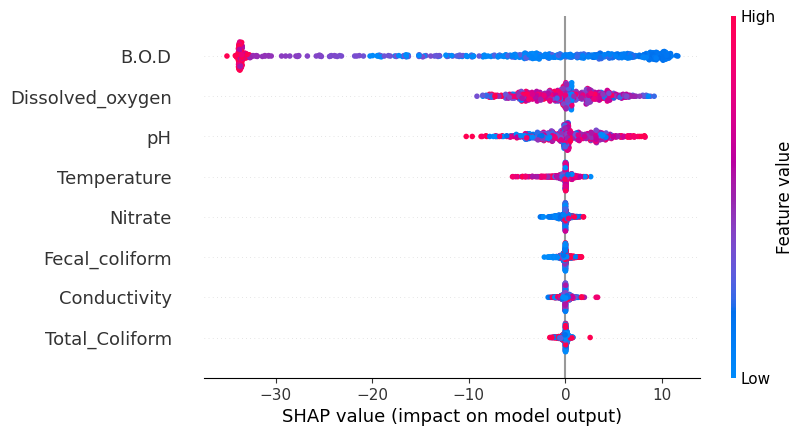

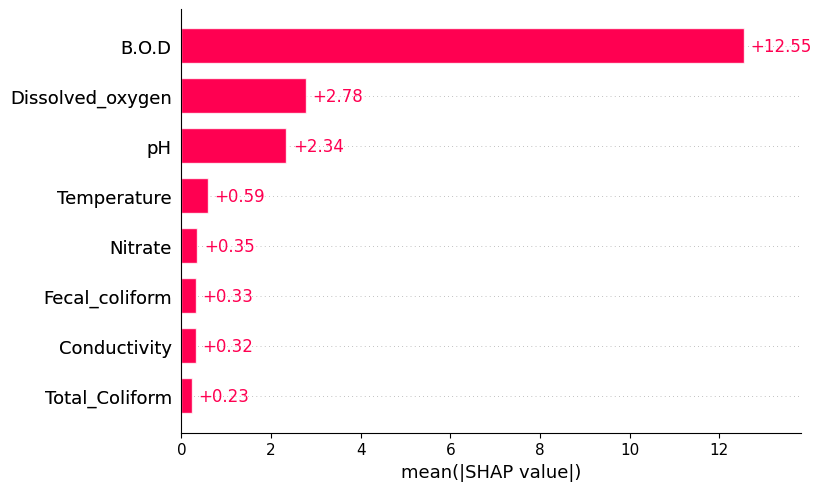

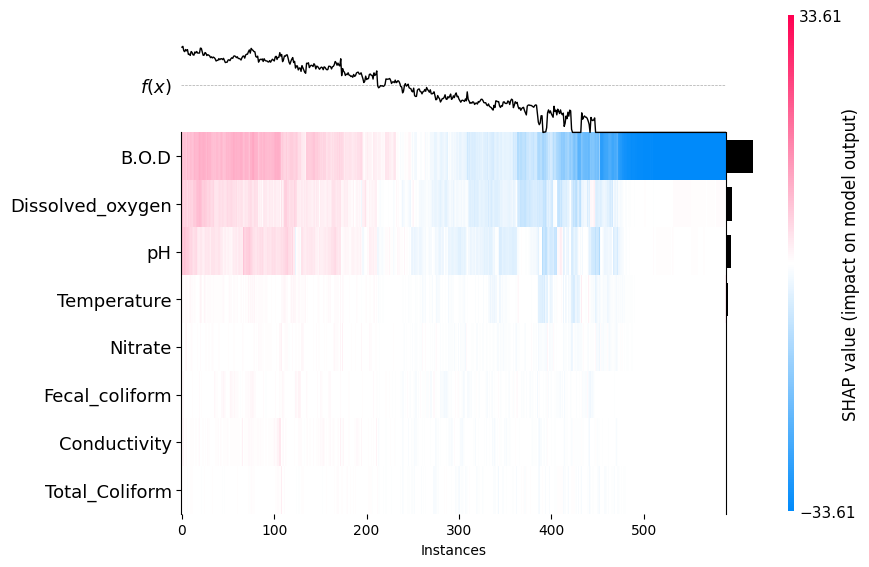

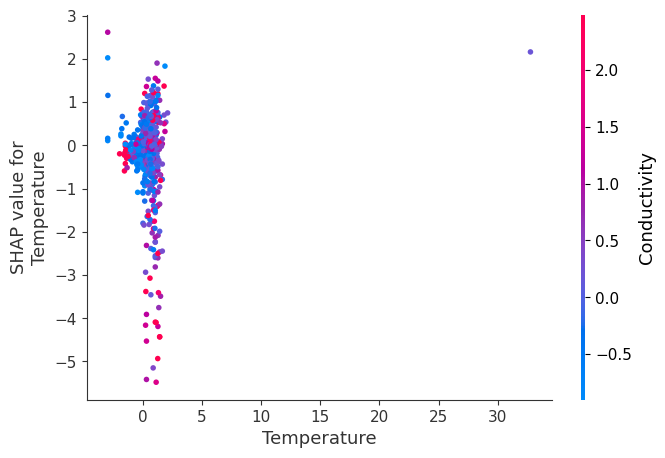

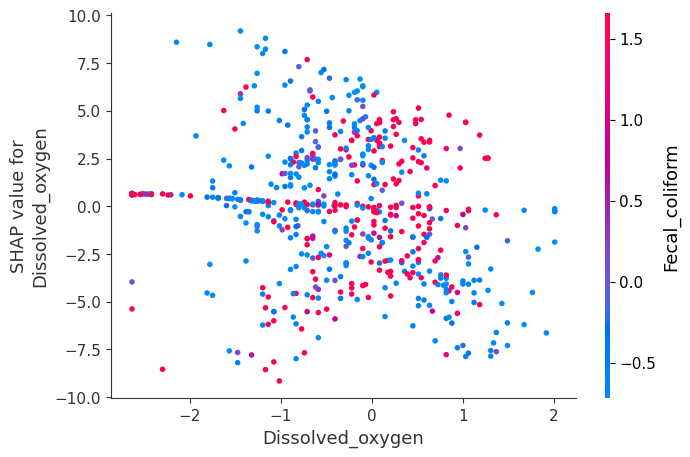

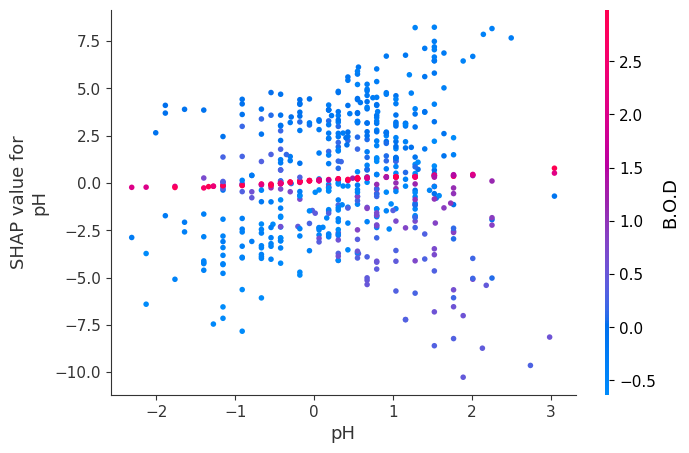

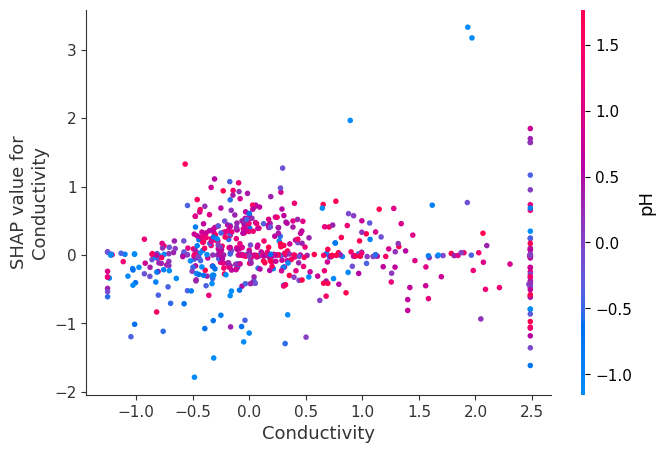

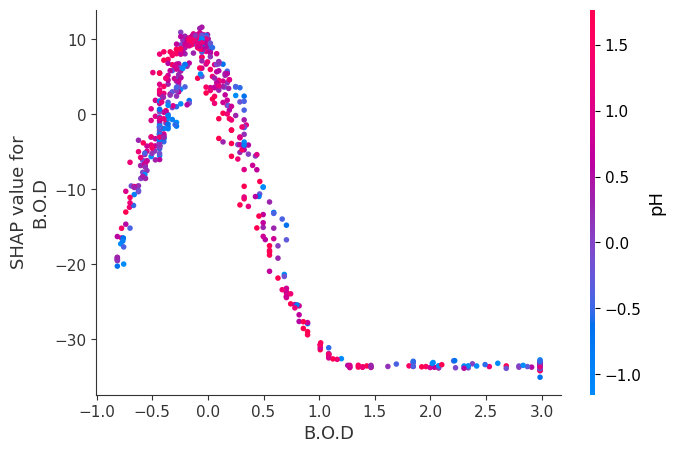

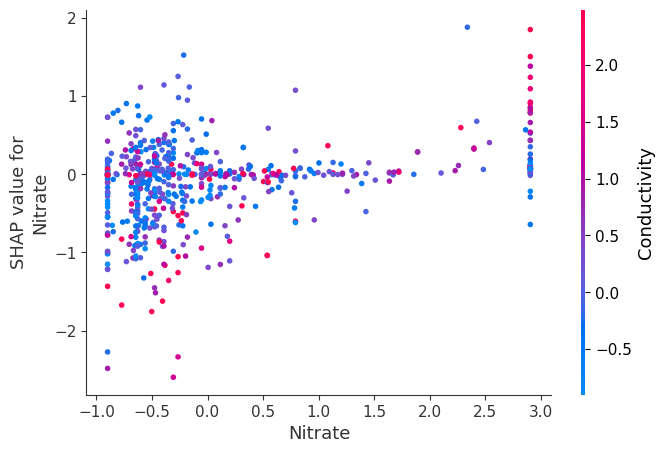

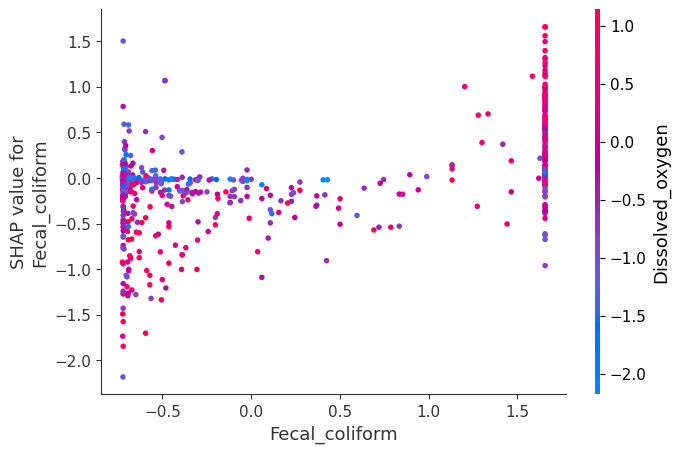

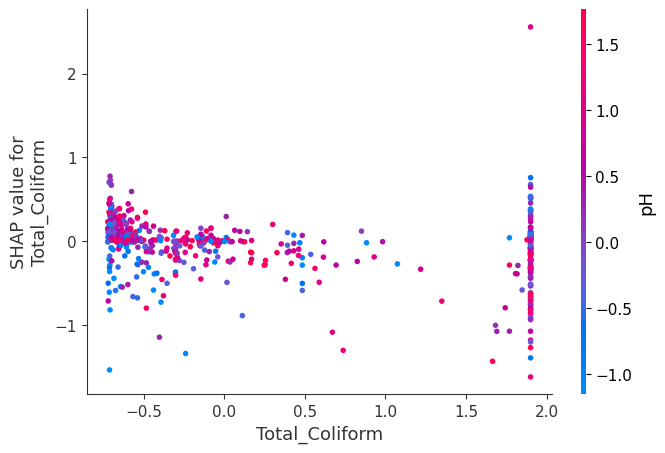

In [58]:
# Explain Class # 2 : Poor
explain_class(explanation, class_idx=2)


--- Class 0 (Excellent) ---


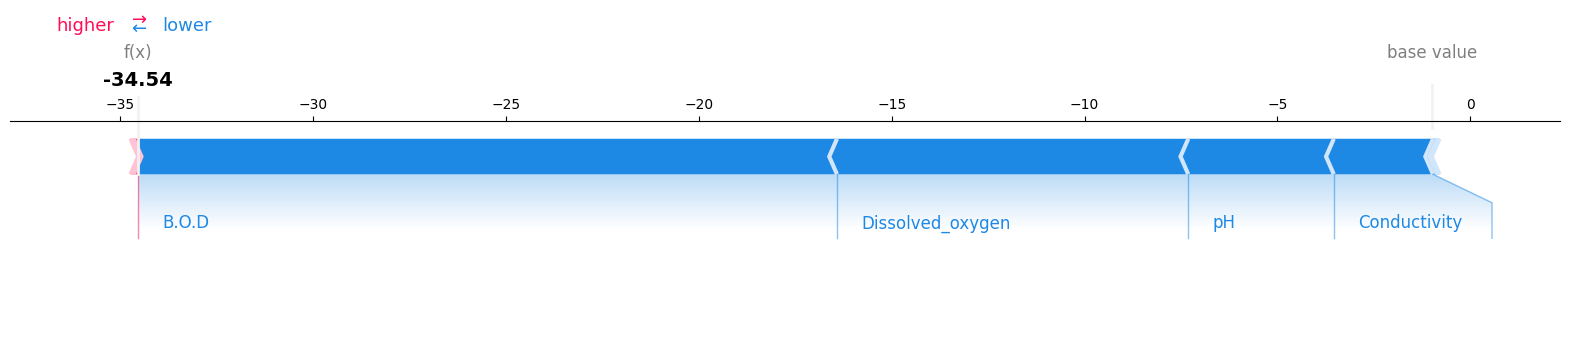

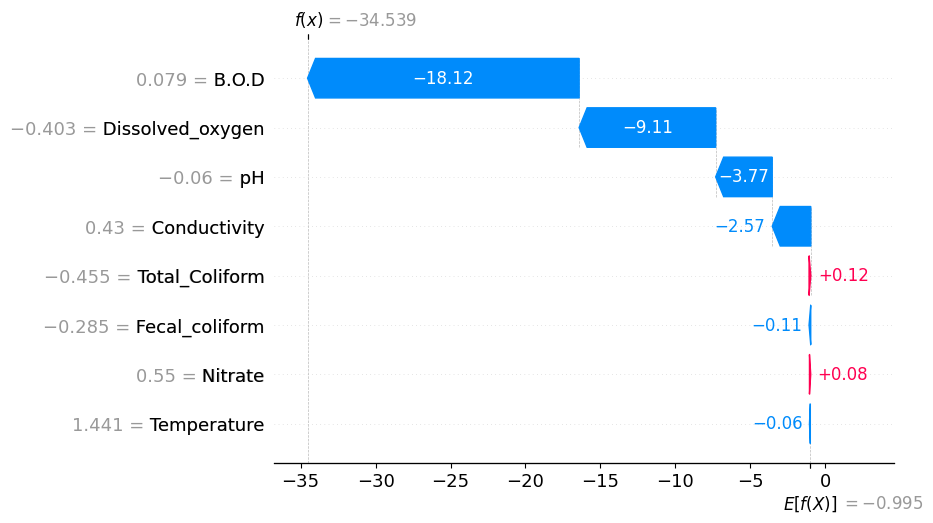

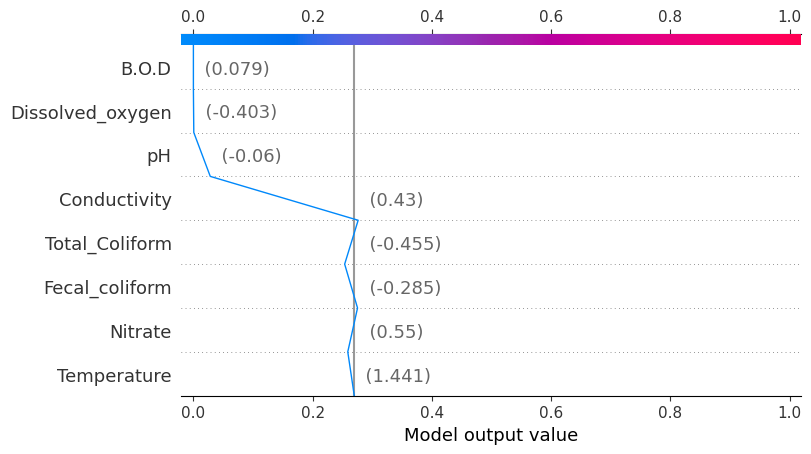


--- Class 1 (Good) ---


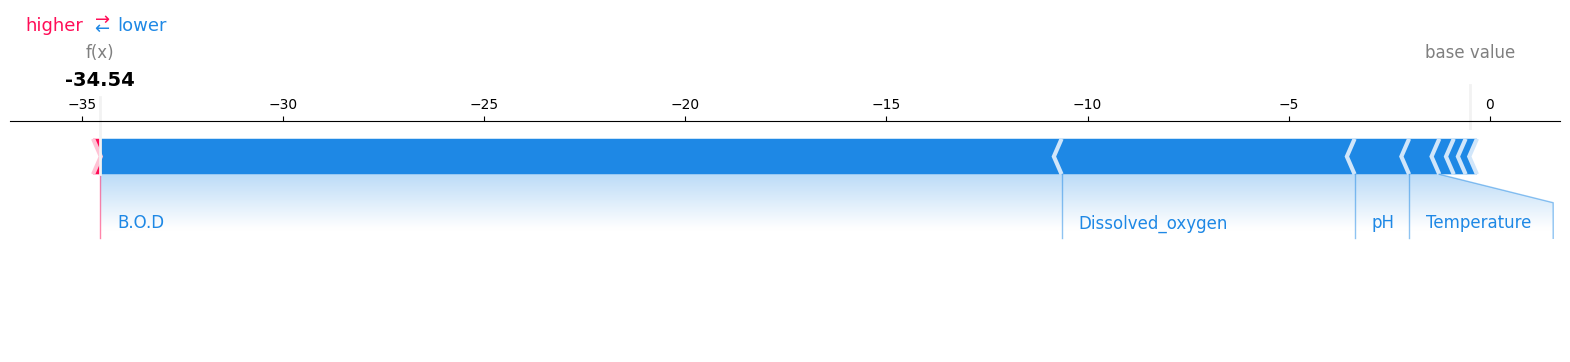

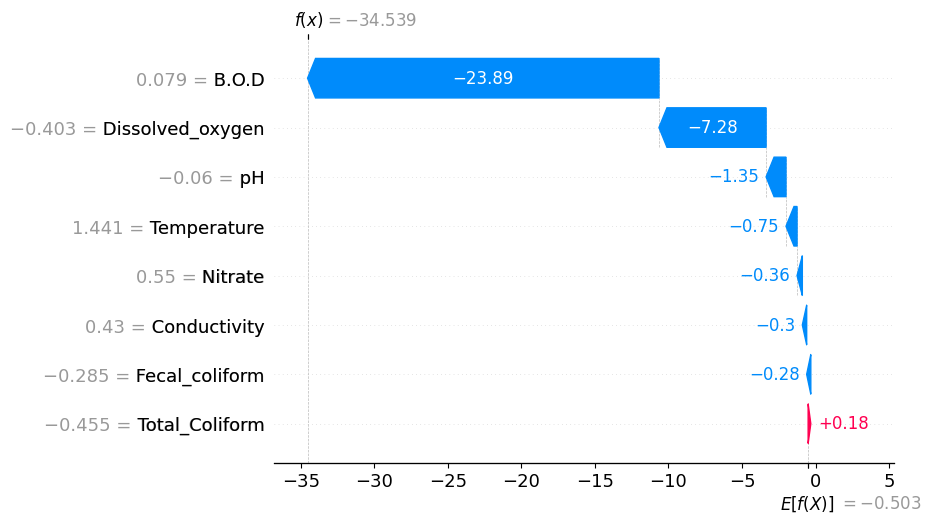

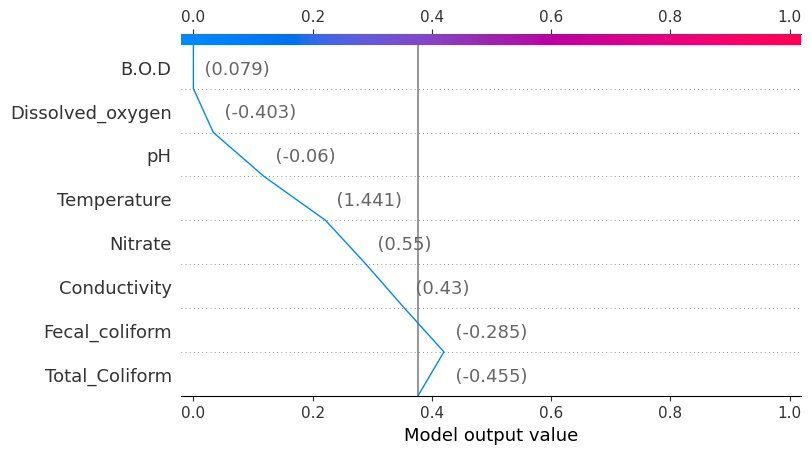


--- Class 2 (Poor) ---


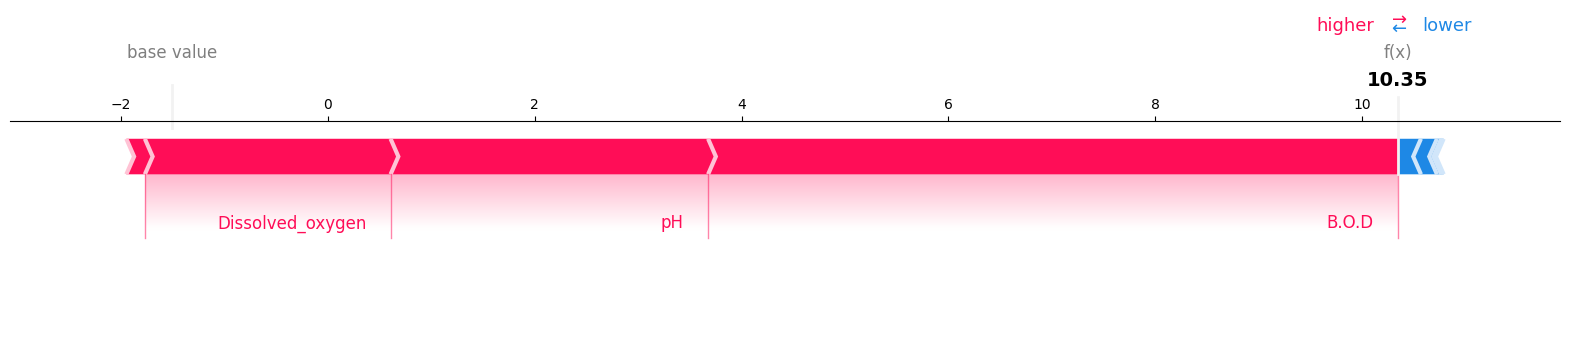

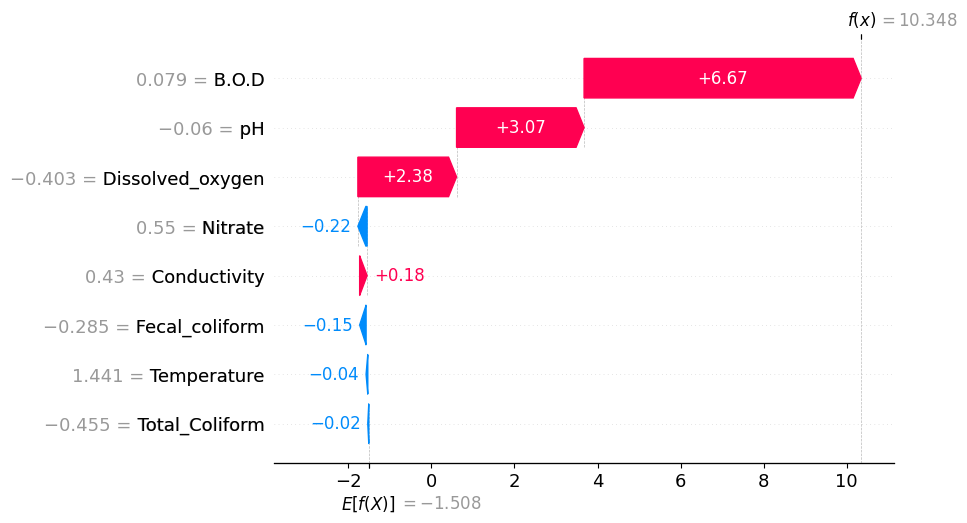

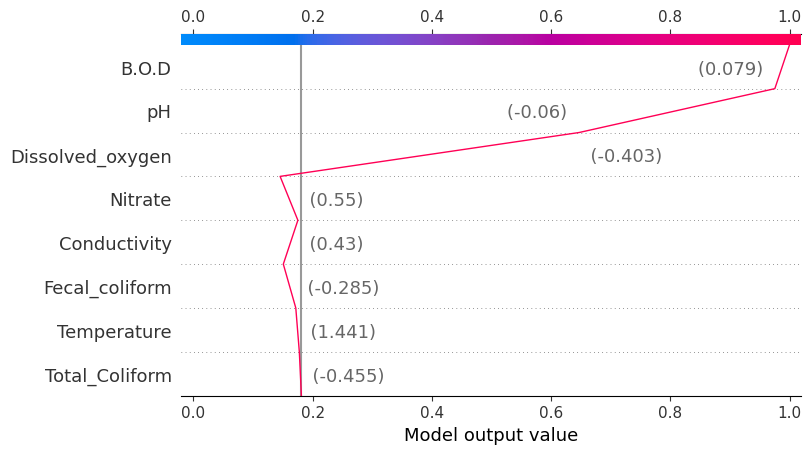


--- Class 3 (Very Poor) ---


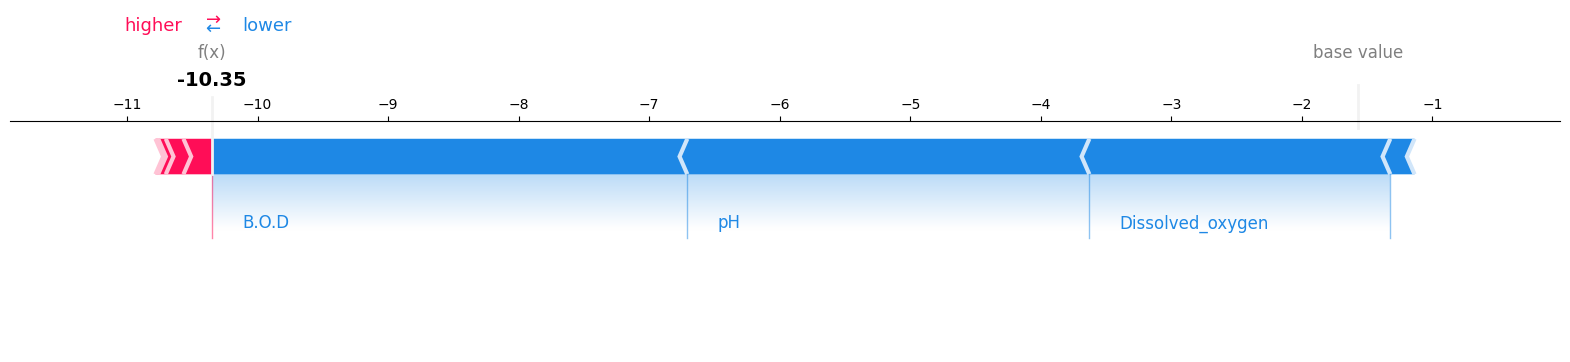

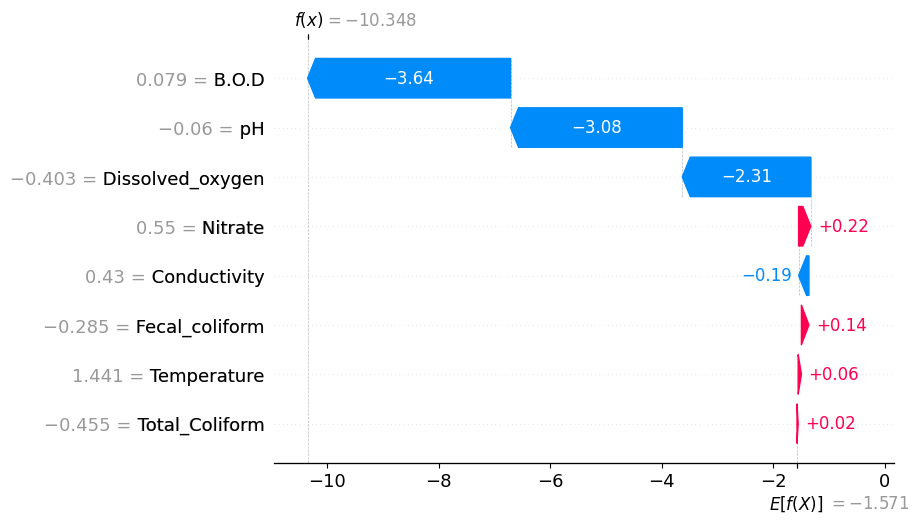

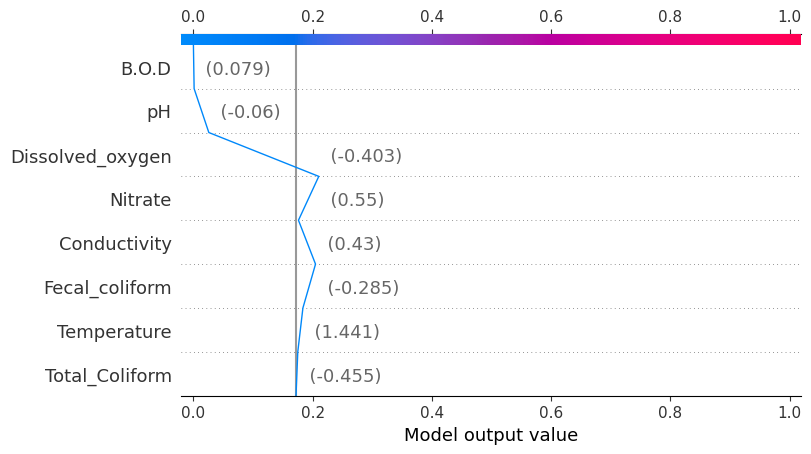

In [59]:
# Explain for test sample # 150
plot_all_for(explanation, sample_idx=150)